/tmp/ipykernel_47/877980001.py:106: RuntimeWarning: divide by zero encountered in divide
  cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)
/tmp/ipykernel_47/877980001.py:109: RuntimeWarning: invalid value encountered in divide
  cosmic_ray = cosmic_ray / cosmic_ray.max()


  Spectrum_ID  Wavelength Intensity_Type  Intensity
0  Spectrum_1   -1.000000  Full_Spectrum   1.149361
1  Spectrum_1   -0.998045  Full_Spectrum   0.959133
2  Spectrum_1   -0.996090  Full_Spectrum   1.104447
3  Spectrum_1   -0.994135  Full_Spectrum   0.857521
4  Spectrum_1   -0.992180  Full_Spectrum   1.149939
Cosmic Ray Peaks for Spectrum 1:
Position: 0.6070381231671553, Intensity: 2.561265373285242
Position: 0.632453567937439, Intensity: 2.5170417583064513
Position: 0.653958944281525, Intensity: 2.688014021234653
Cosmic Ray Peaks for Spectrum 2:
Position: -0.9335288367546433, Intensity: 2.525779623932937
Position: -0.9237536656891495, Intensity: 2.6894152523779287
Position: -0.9198435972629521, Intensity: 2.774510160239684
Cosmic Ray Peaks for Spectrum 3:
Position: -0.8944281524926686, Intensity: 2.5684618284957694
Position: -0.8905180840664711, Intensity: 2.551119599488476
Position: -0.8826979472140762, Intensity: 2.841565731759415
Cosmic Ray Peaks for Spectrum 4:
Cosmic Ray Peaks f

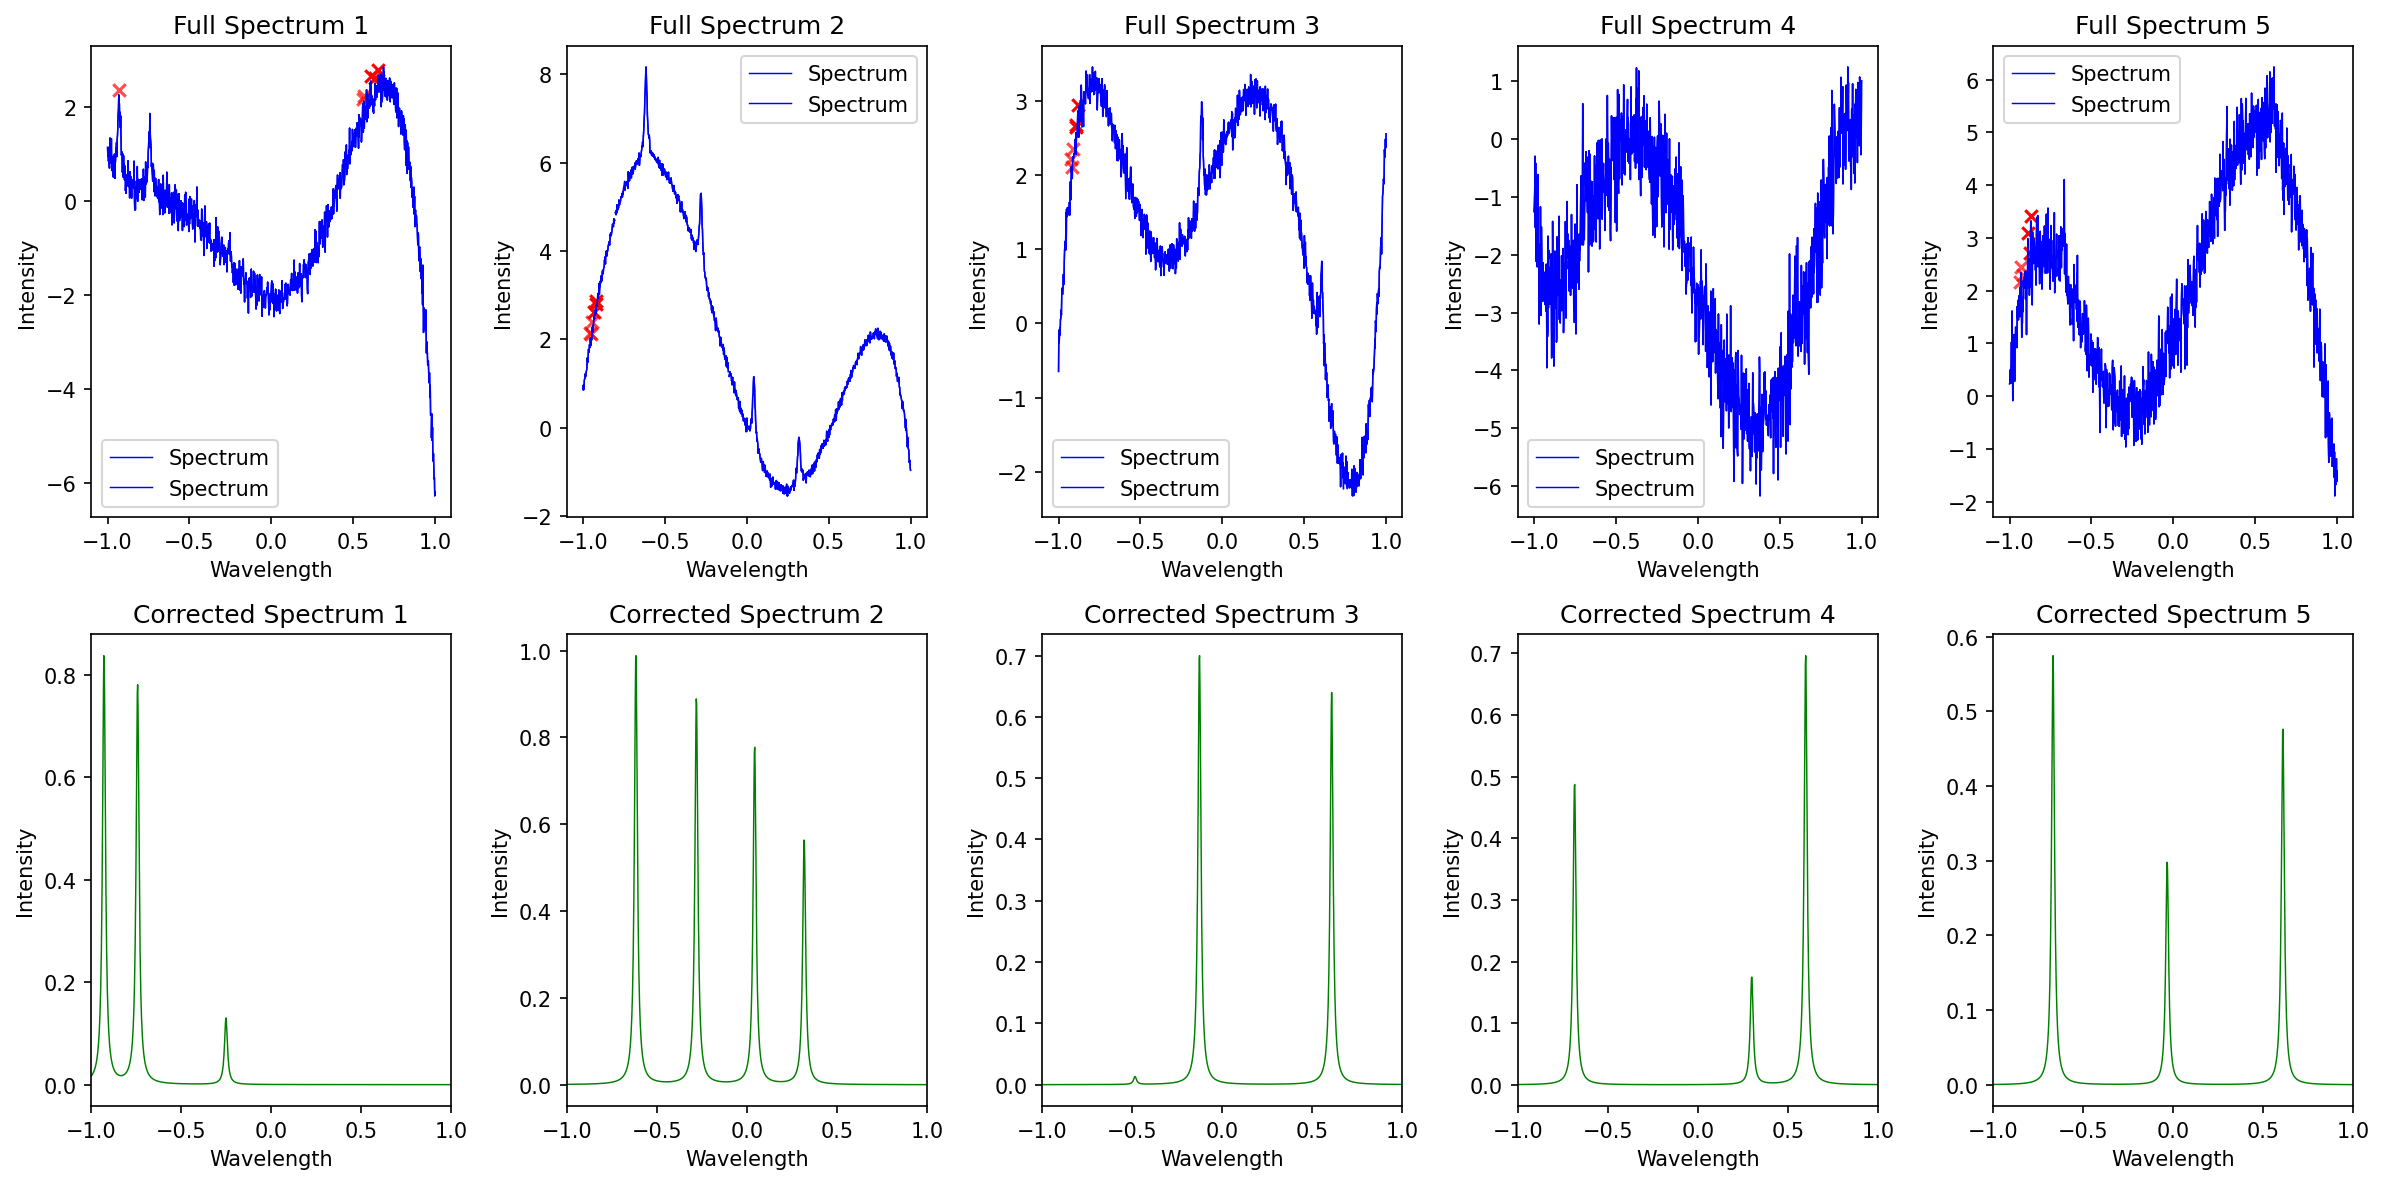

In [24]:
# SYNTHETIC SPECTRA (mark cosmic rays, new structure, best resolution)
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import matplotlib.pyplot as plt

# 1. INPUT PARAMETERS
class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(-1, 1, self.pixels)
        self.full_spectra_list = []
        self.raman_spectra_list = []

    # 2. CHEBYSHEV BASELINE    
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
    
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(np.array(x)))
     
        return chebyshev_vals
    
    def generate_spectrum(self):
        # Randomly select polynomial order for Chebyshev baseline
        poly_order = np.random.randint(self.poly_order_range[-1], self.poly_order_range[1] + 1)

        # Initialize an empty array to store the Chebyshev coefficients
        cheby_baseline_coefficients = np.random.uniform(-1, 1, poly_order + 1)

        # Generate Chebyshev coefficients iteratively
        for i in range(poly_order + 1):
            cheby_baseline_coefficients[i] = np.random.uniform(-1, 1)

        # Generate Chebyshev baseline
        self.cheby_baseline = self.chebyshev_polynomial(self.wavelengths, *cheby_baseline_coefficients)
    
    # 3. LORENTZIAN PEAKS
    def add_lorentzian_peaks(self):
        # Define parameters for Lorentzian peaks
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        peak_amplitudes = np.random.uniform(0, 1, num_peaks)
        peak_positions = np.random.uniform(-1, 1, num_peaks)
        peak_width = 1 / (self.pixels * 0.1)

        # Initialize peaks array
        peaks = np.zeros_like(self.wavelengths)

        # Add Lorentzian peaks to spectrum
        for i in range(num_peaks):
            peaks += peak_amplitudes[i] * (peak_width ** 2) / ((self.wavelengths - peak_positions[i]) ** 2 + peak_width ** 2)

        # Update peaks attribute
        self.peaks = peaks

        # Add peaks to Chebyshev baseline
        self.peaky_cheby = self.peaks + self.cheby_baseline
    
    # 4. NOISE GENERATION
    def add_gaussian_noise(self, noise_amplitude_range=(0, 1)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.cheby_baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        total_noise = noise * noise_amplitudes
        
        # Add noise to peaky cheby spectra
        self.noisy_peaky_cheby = self.peaky_cheby + total_noise

    # 5. COSMIC RAYS
    # Lorentzian peak with a width of 0, amplitudes: randomized between 0.8 & L2-norm of complete signal
    def add_cosmic_rays(self, num_cosmic_rays):
        cosmic_rays_spectrum = self.noisy_peaky_cheby.copy()
    
        # Calculate L2-norm of complete signal
        l2_norm = np.linalg.norm(cosmic_rays_spectrum)
    
        for _ in range(num_cosmic_rays):
            # Generate random amplitude between 0.8 & L2-norm of complete signal
            cosmic_ray_amplitude = np.random.uniform(0.8, l2_norm)
        
            # Randomly select position for cosmic ray
            position = np.random.randint(0, len(cosmic_rays_spectrum))
        
            # Create cosmic ray using y = 1 / (x - position)^2  
            cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)

            # Normalize cosmic ray
            cosmic_ray = cosmic_ray / cosmic_ray.max()

            # Add cosmic ray to spectrum
            cosmic_rays_spectrum += cosmic_ray

        # Update full synthetic spectrum with cosmic rays
        full_spectrum = cosmic_rays_spectrum + self.noisy_peaky_cheby
        self.full_spectra_list.append(full_spectrum)

        # Update Raman spectrum (only peaks)
        raman_spectrum = self.peaks
        self.raman_spectra_list.append(raman_spectrum)

    def save_to_csv(self, filename='synthetic_spectra.csv'):
        # Create a list to store individual spectra as dictionaries
        spectra_data = []

        for i, (full_spectrum, raman_spectrum) in enumerate(zip(self.full_spectra_list, self.raman_spectra_list), start=1):
            # Create a dictionary for each data point in a spectrum
            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, full_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Full_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, raman_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Raman_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

        # Convert list of dictionaries to a DataFrame
        df = pd.DataFrame(spectra_data)

        # Save DataFrame to CSV file
        df.to_csv(filename, index=False)

        return df

# Parameters
pixels = 1024
poly_order_range = (2, 5)
num_peaks_range = (3, 6)
snr_range = 20
cosmic_ray_prob = 0.1
num_spectra = 5

synthetic_data_generator = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)

# Generate synthetic spectra
for _ in range(num_spectra):
    # Randomly sample parameter values within specified ranges
    synthetic_data_generator.generate_spectrum()
    synthetic_data_generator.add_lorentzian_peaks()
    synthetic_data_generator.add_gaussian_noise()
    
    # Generate a random number of cosmic rays between 1 & 3
    num_cosmic_rays = np.random.randint(1, 3)
    synthetic_data_generator.add_cosmic_rays(num_cosmic_rays)

# Save X & Y values
output_file_path = 'synthetic_spectra.csv'
df = synthetic_data_generator.save_to_csv(filename=output_file_path)

# Display DataFrame
print(df.head())

# Set up a figure with higher resolution (DPI)
plt.figure(figsize=(16, 8), dpi=150)

# Plot full synthetic spectra with cosmic rays marked
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)

    # Plot with a smoother line & more data points
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='blue', label='Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(synthetic_data_generator.full_spectra_list[i])

    # Set a threshold to distinguish cosmic rays from other peaks
    cosmic_ray_threshold = 2.5  

    # Filter peaks (only above threshold)
    cosmic_ray_peaks = [peak for peak in peaks if synthetic_data_generator.full_spectra_list[i][peak] > cosmic_ray_threshold]

    # Sort cosmic ray peaks by intensity in descending order
    sorted_cosmic_ray_peaks = sorted(cosmic_ray_peaks, key=lambda peak: synthetic_data_generator.full_spectra_list[i][peak], reverse=True)

    # Count how many cosmic ray peaks were identified
    num_cosmic_rays = len(sorted_cosmic_ray_peaks)

    # Determine number of cosmic rays to mark, capped at 3
    num_cosmic_rays_to_mark = min(3, num_cosmic_rays)
    
    # Mark cosmic ray positions with "x" above peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(synthetic_data_generator.wavelengths[peak], synthetic_data_generator.full_spectra_list[i][peak] + 0.10, marker='x', color='red')

    # Adjust plot settings
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    
    # Print peak information
    print(f'Cosmic Ray Peaks for Spectrum {i + 1}:')
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        print(f'Position: {synthetic_data_generator.wavelengths[peak]}, Intensity: {synthetic_data_generator.full_spectra_list[i][peak]}')

# Plot corrected spectra
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + num_spectra + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.raman_spectra_list[i], color='green', linewidth=0.7)
    plt.title(f'Corrected Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())

# Show plots for original spectra with cosmic rays marked
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)

    # Plot with a smoother line & more data points
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='blue', label='Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(synthetic_data_generator.full_spectra_list[i])

    # Set a threshold to distinguish cosmic rays from other peaks
    cosmic_ray_threshold = 2.0  

    # Filter peaks (only above threshold)
    cosmic_ray_peaks = [peak for peak in peaks if synthetic_data_generator.full_spectra_list[i][peak] > cosmic_ray_threshold]

    # Mark cosmic ray positions with "x" above peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(synthetic_data_generator.wavelengths[peak], synthetic_data_generator.full_spectra_list[i][peak] + 0.10, marker='x', color='red', alpha=0.7)

    # Adjust plot settings
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    
    # Print peak information
    print(f'Cosmic Ray Peaks for Spectrum {i + 1}:')
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        print(f'Position: {synthetic_data_generator.wavelengths[peak]}, Intensity: {synthetic_data_generator.full_spectra_list[i][peak]}')

# Show plots
plt.tight_layout()
plt.show()

/tmp/ipykernel_47/1488170805.py:107: RuntimeWarning: divide by zero encountered in divide
  cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)
/tmp/ipykernel_47/1488170805.py:110: RuntimeWarning: invalid value encountered in divide
  cosmic_ray = cosmic_ray / cosmic_ray.max()


  Spectrum_ID  Wavelength Intensity_Type  Intensity
0  Spectrum_1   -1.000000  Full_Spectrum   1.449335
1  Spectrum_1   -0.998045  Full_Spectrum   1.034044
2  Spectrum_1   -0.996090  Full_Spectrum   1.192852
3  Spectrum_1   -0.994135  Full_Spectrum   1.227842
4  Spectrum_1   -0.992180  Full_Spectrum   1.162717
Cosmic Ray Peaks for Spectrum 1:
Position: -0.9628543499511242, Intensity: 1.7011352670376945
Position: -0.9472140762463344, Intensity: 1.8087842752153676
Position: -0.9335288367546433, Intensity: 1.8275323570507904
Cosmic Ray Peaks for Spectrum 2:
Position: 0.11632453567937429, Intensity: 1.5456640550634444
Position: 0.12609970674486792, Intensity: 1.5048497832222822
Position: 0.1300097751710656, Intensity: 1.735773906626358
Cosmic Ray Peaks for Spectrum 3:
Position: -0.2512218963831867, Intensity: 1.6064633111542914
Position: -0.22776148582600197, Intensity: 1.7193582798630236
Position: -0.2160312805474096, Intensity: 1.7593348491914331
Cosmic Ray Peaks for Spectrum 4:
Position

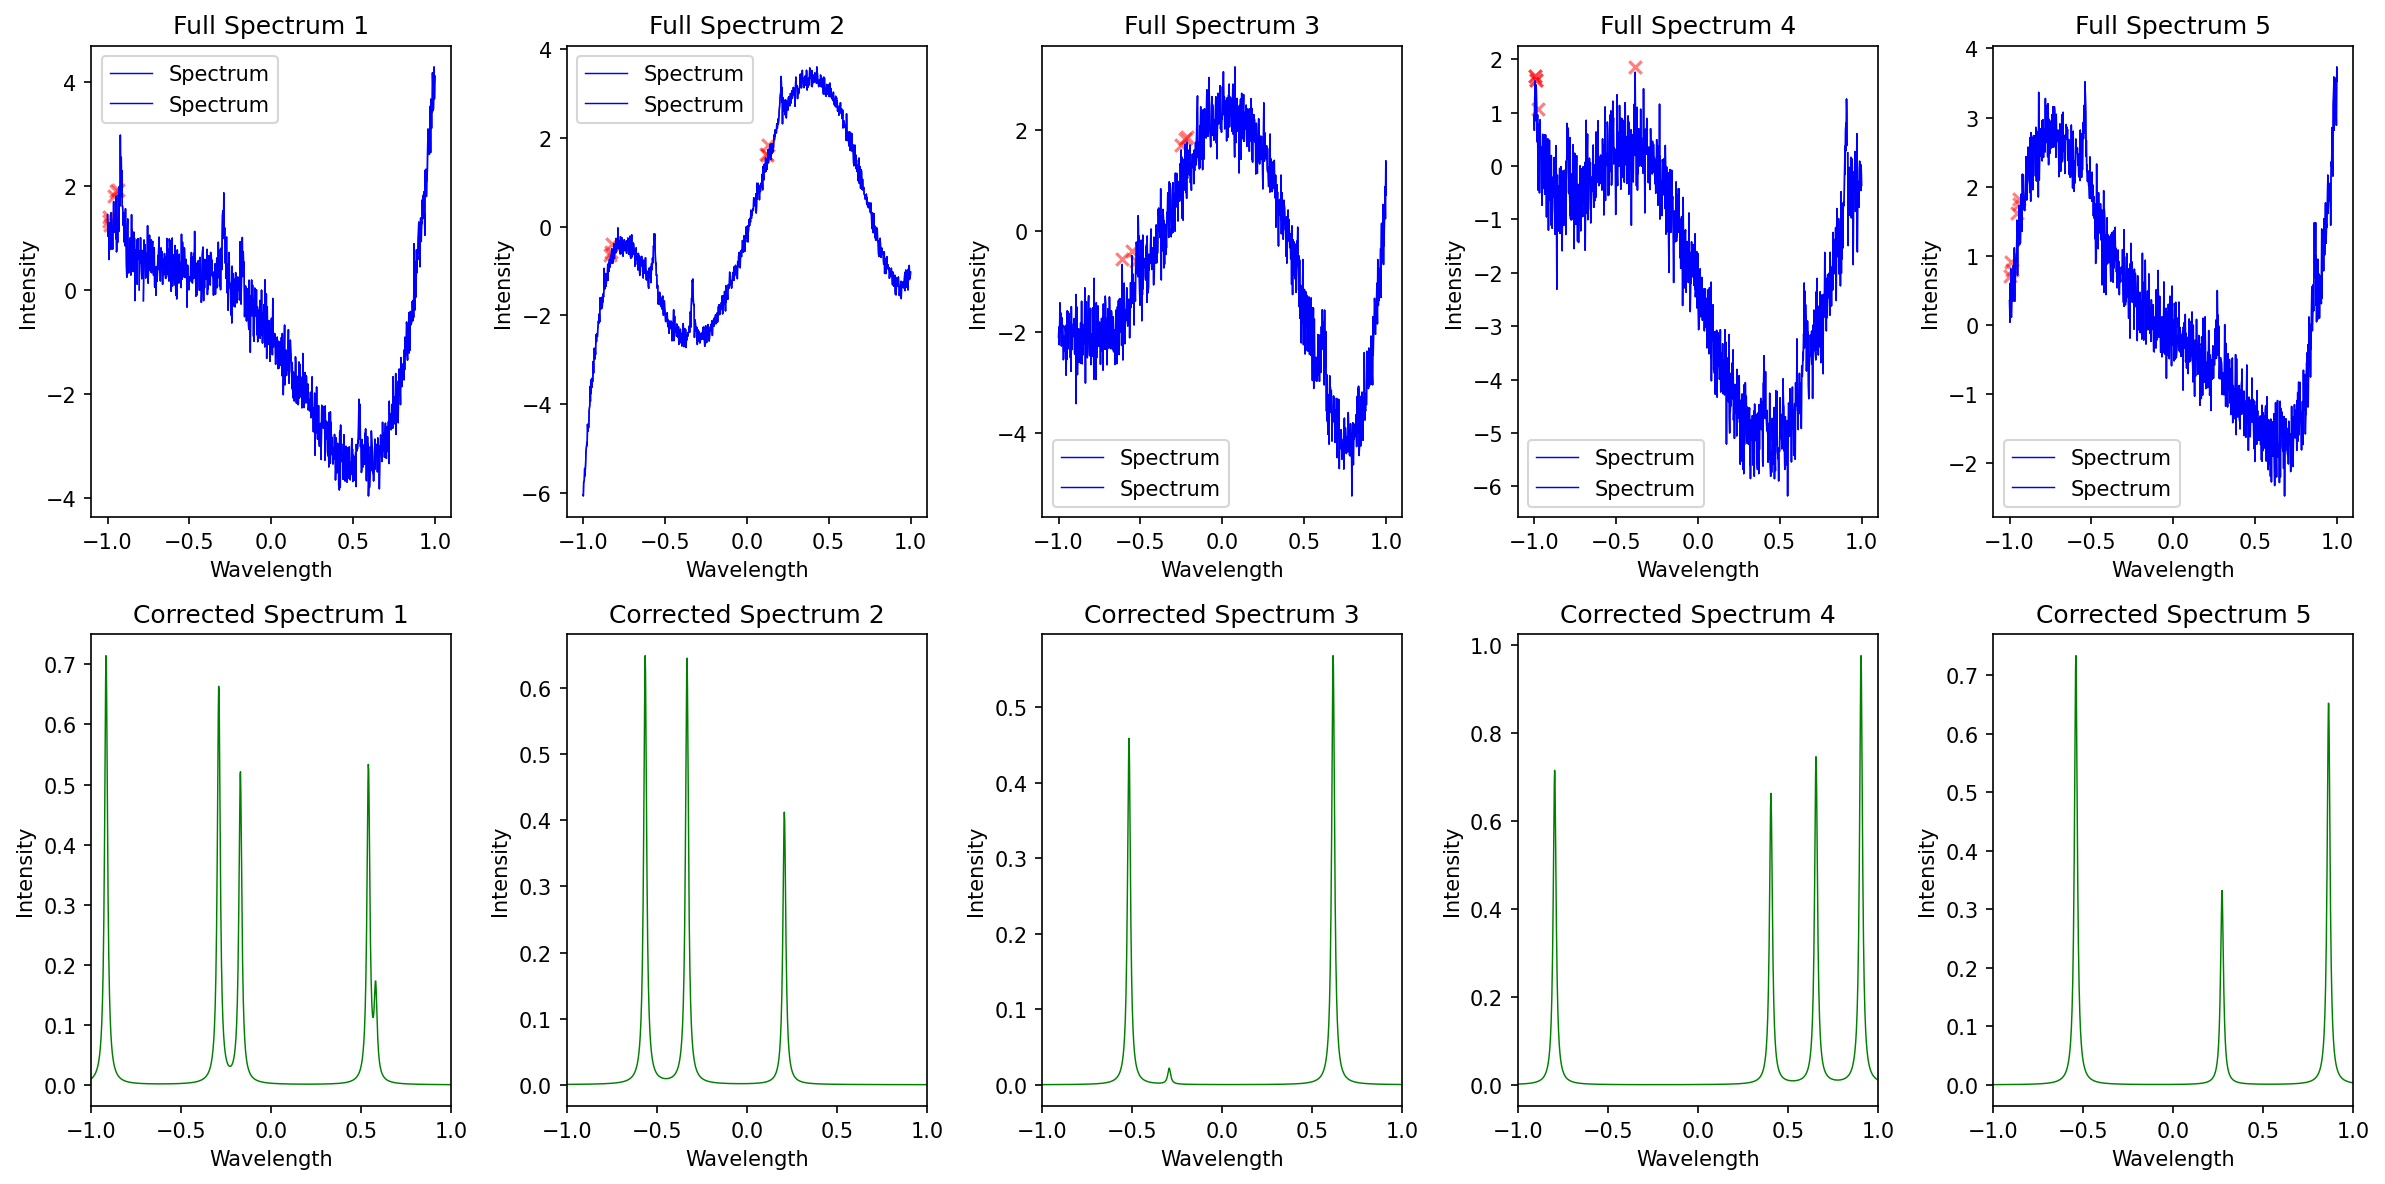

In [25]:
# SYNTHETIC SPECTRA (mark cosmic rays, new structure, best resolution)
# DINAMIC THRESHOLD (maybe more accurately results)
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import matplotlib.pyplot as plt

# 1. INPUT PARAMETERS
class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(-1, 1, self.pixels)
        self.full_spectra_list = []
        self.raman_spectra_list = []

    # 2. CHEBYSHEV BASELINE    
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
    
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(np.array(x)))
     
        return chebyshev_vals
    
    def generate_spectrum(self):
        # Randomly select polynomial order for Chebyshev baseline
        poly_order = np.random.randint(self.poly_order_range[-1], self.poly_order_range[1] + 1)

        # Initialize an empty array to store the Chebyshev coefficients
        cheby_baseline_coefficients = np.random.uniform(-1, 1, poly_order + 1)

        # Generate Chebyshev coefficients iteratively
        for i in range(poly_order + 1):
            cheby_baseline_coefficients[i] = np.random.uniform(-1, 1)

        # Generate Chebyshev baseline
        self.cheby_baseline = self.chebyshev_polynomial(self.wavelengths, *cheby_baseline_coefficients)
    
    # 3. LORENTZIAN PEAKS
    def add_lorentzian_peaks(self):
        # Define parameters for Lorentzian peaks
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        peak_amplitudes = np.random.uniform(0, 1, num_peaks)
        peak_positions = np.random.uniform(-1, 1, num_peaks)
        peak_width = 1 / (self.pixels * 0.1)

        # Initialize peaks array
        peaks = np.zeros_like(self.wavelengths)

        # Add Lorentzian peaks to spectrum
        for i in range(num_peaks):
            peaks += peak_amplitudes[i] * (peak_width ** 2) / ((self.wavelengths - peak_positions[i]) ** 2 + peak_width ** 2)

        # Update peaks attribute
        self.peaks = peaks

        # Add peaks to Chebyshev baseline
        self.peaky_cheby = self.peaks + self.cheby_baseline
    
    # 4. NOISE GENERATION
    def add_gaussian_noise(self, noise_amplitude_range=(0, 1)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.cheby_baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        total_noise = noise * noise_amplitudes
        
        # Add noise to peaky cheby spectra
        self.noisy_peaky_cheby = self.peaky_cheby + total_noise

    # 5. COSMIC RAYS
    # Lorentzian peak with a width of 0, amplitudes: randomized between 0.8 & L2-norm of complete signal
    def add_cosmic_rays(self, num_cosmic_rays):
        cosmic_rays_spectrum = self.noisy_peaky_cheby.copy()
    
        # Calculate L2-norm of complete signal
        l2_norm = np.linalg.norm(cosmic_rays_spectrum)
    
        for _ in range(num_cosmic_rays):
            # Generate random amplitude between 0.8 & L2-norm of complete signal
            cosmic_ray_amplitude = np.random.uniform(0.8, l2_norm)
        
            # Randomly select position for cosmic ray
            position = np.random.randint(0, len(cosmic_rays_spectrum))
        
            # Create cosmic ray using y = 1 / (x - position)^2  
            cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)

            # Normalize cosmic ray
            cosmic_ray = cosmic_ray / cosmic_ray.max()

            # Add cosmic ray to spectrum
            cosmic_rays_spectrum += cosmic_ray

        # Update full synthetic spectrum with cosmic rays
        full_spectrum = cosmic_rays_spectrum + self.noisy_peaky_cheby
        self.full_spectra_list.append(full_spectrum)

        # Update Raman spectrum (only peaks)
        raman_spectrum = self.peaks
        self.raman_spectra_list.append(raman_spectrum)

    def save_to_csv(self, filename='synthetic_spectra.csv'):
        # Create a list to store individual spectra as dictionaries
        spectra_data = []

        for i, (full_spectrum, raman_spectrum) in enumerate(zip(self.full_spectra_list, self.raman_spectra_list), start=1):
            # Create a dictionary for each data point in a spectrum
            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, full_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Full_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

            for j, (wavelength, intensity) in enumerate(zip(self.wavelengths, raman_spectrum)):
                data_point = {
                    'Spectrum_ID': f'Spectrum_{i}',
                    'Wavelength': wavelength,
                    'Intensity_Type': 'Raman_Spectrum',
                    'Intensity': intensity
                }
                spectra_data.append(data_point)

        # Convert list of dictionaries to a DataFrame
        df = pd.DataFrame(spectra_data)

        # Save DataFrame to CSV file
        df.to_csv(filename, index=False)

        return df

# Parameters
pixels = 1024
poly_order_range = (2, 5)
num_peaks_range = (3, 6)
snr_range = 20
cosmic_ray_prob = 0.1
num_spectra = 5

synthetic_data_generator = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)

# Generate synthetic spectra
for _ in range(num_spectra):
    # Randomly sample parameter values within specified ranges
    synthetic_data_generator.generate_spectrum()
    synthetic_data_generator.add_lorentzian_peaks()
    synthetic_data_generator.add_gaussian_noise()
    
    # Generate a random number of cosmic rays between 1 & 3
    num_cosmic_rays = np.random.randint(1, 3)
    synthetic_data_generator.add_cosmic_rays(num_cosmic_rays)

# Save X & Y values
output_file_path = 'synthetic_spectra.csv'
df = synthetic_data_generator.save_to_csv(filename=output_file_path)

# Display DataFrame
print(df.head())

# Set up a figure with higher resolution (DPI)
plt.figure(figsize=(16, 8), dpi=150)

# Plot full synthetic spectra with cosmic rays marked
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)

    # Plot with a smoother line & more data points
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='blue', label='Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(synthetic_data_generator.full_spectra_list[i])

    # Calculate median intensity of identified peaks
    median_intensity = np.median(synthetic_data_generator.full_spectra_list[i][peaks])

    # Set a dynamic threshold based on median intensity
    cosmic_ray_threshold = median_intensity * 1.5  # Adjust the multiplier as needed

    # Filter peaks (only above dynamic threshold)
    cosmic_ray_peaks = [peak for peak in peaks if synthetic_data_generator.full_spectra_list[i][peak] > cosmic_ray_threshold]

    # Ensure at least 1 & at most 3 cosmic rays (no mark more than expected)
    num_cosmic_rays = min(max(len(cosmic_ray_peaks), 1), 3)

    # Sort cosmic ray peaks by intensity in descending order
    sorted_cosmic_ray_peaks = sorted(cosmic_ray_peaks, key=lambda peak: synthetic_data_generator.full_spectra_list[i][peak], reverse=True)

    # Determine number of cosmic rays to mark
    num_cosmic_rays_to_mark = min(num_cosmic_rays, len(sorted_cosmic_ray_peaks))

    # Mark cosmic ray positions with "x" above peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(synthetic_data_generator.wavelengths[peak], synthetic_data_generator.full_spectra_list[i][peak] + 0.10, marker='x', color='red', alpha=0.5)

    # Adjust plot settings
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    
# Plot corrected spectra
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + num_spectra + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.raman_spectra_list[i], color='green', linewidth=0.7)
    plt.title(f'Corrected Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.xlim(synthetic_data_generator.wavelengths.min(), synthetic_data_generator.wavelengths.max())

# Show plots for original spectra with cosmic rays marked
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)

    # Plot with a smoother line & more data points
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='blue', label='Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(synthetic_data_generator.full_spectra_list[i])

    # Set a threshold to distinguish cosmic rays from other peaks
    cosmic_ray_threshold = 1.5   

    # Filter peaks (only above threshold)
    cosmic_ray_peaks = [peak for peak in peaks if synthetic_data_generator.full_spectra_list[i][peak] > cosmic_ray_threshold]

    # Mark cosmic ray positions with "x" above peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(synthetic_data_generator.wavelengths[peak], synthetic_data_generator.full_spectra_list[i][peak] + 0.10, marker='x', color='red', alpha=0.5)

    # Adjust plot settings
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    
    # Print peak information
    print(f'Cosmic Ray Peaks for Spectrum {i + 1}:')
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        print(f'Position: {synthetic_data_generator.wavelengths[peak]}, Intensity: {synthetic_data_generator.full_spectra_list[i][peak]}')

# Show plots
plt.tight_layout()
plt.show()

Cosmic Ray Indices for Spectrum 1: [ 647  726  878 1023]
Cosmic Ray Indices for Spectrum 2: []
Cosmic Ray Indices for Spectrum 3: [  54  109  138  188  275  549  563  659  792  796  869  915 1006]
Cosmic Ray Indices for Spectrum 4: [ 11  38  70  98 159 163 217 222 254 270 275 295 303 319 322 345 392 416
 420 435 463 553 571 600 643 654 675 687 750 791 844 902 943 956 959 980
 990 996]
Cosmic Ray Indices for Spectrum 5: [  89  294  845 1023]


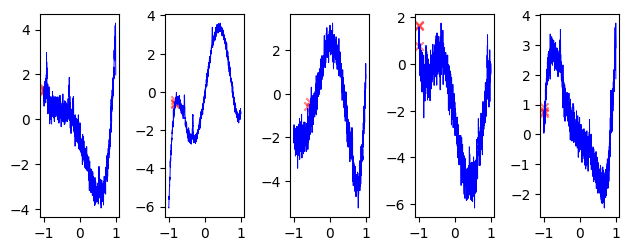

Value at index 89: 2.2287947166422826
Value at index 294: 2.669198537565355
Value at index 845: 2.087612186405707


In [26]:
# CLEAN RAYS (using specific spectrum data, before 2nd difference was calculated using entire dataset)
# handle boundary cases & integer-based indexing 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id].copy()  # copy to avoid modifying the original DataFrame

    # Cosmic Ray Removal
    # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
    first_difference = np.diff(spectrum_data['Intensity'], n=1)
    second_difference = np.diff(first_difference, n=1)

    # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
    threshold = 2.0 
    cosmic_ray_indices = np.where(second_difference > threshold)[0]

    # Print or inspect cosmic_ray_indices array
    print(f"Cosmic Ray Indices for Spectrum {i}:", cosmic_ray_indices)             
        
    # 3) Replace these points using custom interpolation
    for index in cosmic_ray_indices:
        # Custom interpolation
        left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
        right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

        left_distance = index - left_index
        right_distance = right_index - index

        left_neighbor = spectrum_data.iloc[left_index]['Intensity']
        right_neighbor = spectrum_data.iloc[right_index]['Intensity']

        # Linear interpolation to replace cosmic ray spike
        interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
        spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

    # Drop duplicate entries in 'Wavelength' column
    spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

    # Append cleaned spectrum to the list
    cleaned_spectra.append(spectrum_data)

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create output directory
output_directory = '/kaggle/working/output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Plot full synthetic spectra with cosmic rays marked
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    plt.subplot(2, len(spectrum_ids), i)

    # Plot with a smoother line & more data points
    plt.plot(data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]['Wavelength'], 
             data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]['Intensity'], 
             color='blue', label='Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]['Intensity'].values)

    # Calculate median intensity of identified peaks
    median_intensity = np.median(data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peaks])

    # Set dynamic threshold based on median intensity
    cosmic_ray_threshold = median_intensity * 1.5
    
    # Filter peaks (only above dynamic threshold)
    cosmic_ray_peaks = [peak for peak in peaks if data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak] > cosmic_ray_threshold]

    # Ensure at least 1 & at most 3 cosmic rays
    num_cosmic_rays = min(max(len(cosmic_ray_peaks), 1), 3)

    # Sort cosmic ray peaks by intensity in descending order
    sorted_cosmic_ray_peaks = sorted(cosmic_ray_peaks, key=lambda peak: data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak], reverse=True)

    # Determine number of cosmic rays to mark
    num_cosmic_rays_to_mark = min(num_cosmic_rays, len(sorted_cosmic_ray_peaks))

    # Mark cosmic ray positions with "x" above peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]['Wavelength'].iloc[peak], 
                    data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak] + 0.10, 
                    marker='x', color='red', alpha=0.5)

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

# Print values cosmic ray indices
for index in cosmic_ray_indices[:3]: 
    value_at_index = second_difference[index]
    print(f"Value at index {index}: {value_at_index}")

Cosmic Ray Indices for Spectrum 1: [ 647  726  878 1023]
Cosmic Ray Indices for Spectrum 2: []
Cosmic Ray Indices for Spectrum 3: [  54  109  138  188  275  549  563  659  792  796  869  915 1006]
Cosmic Ray Indices for Spectrum 4: [ 11  38  70  98 159 163 217 222 254 270 275 295 303 319 322 345 392 416
 420 435 463 553 571 600 643 654 675 687 750 791 844 902 943 956 959 980
 990 996]
Cosmic Ray Indices for Spectrum 5: [  89  294  845 1023]


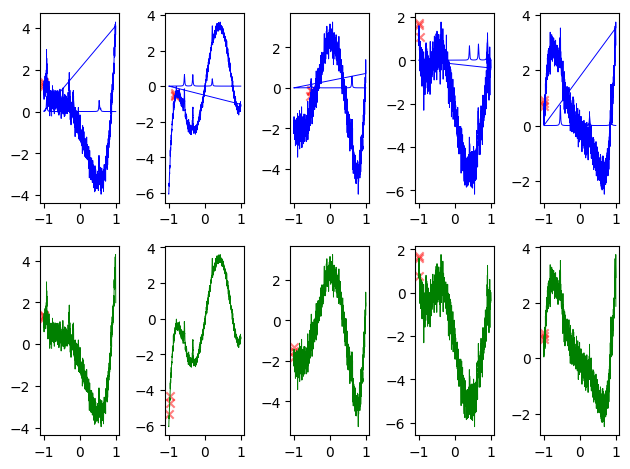

In [27]:
# CLEAN RAYS (using specific spectrum data, before 2nd difference was calculated using entire dataset)
# handle boundary cases & integer-based indexing 
# Adjusting plot code, correcting problem 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.signal

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id].copy()  # to avoid modifying original DataFrame

    # Cosmic Ray Removal
    # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
    first_difference = np.diff(spectrum_data['Intensity'], n=1)
    second_difference = np.diff(first_difference, n=1)

    # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
    threshold = 2.0 
    cosmic_ray_indices = np.where(second_difference > threshold)[0]

    # Print or inspect cosmic_ray_indices array
    print(f"Cosmic Ray Indices for Spectrum {i}:", cosmic_ray_indices)             
        
    # 3) Replace these points using custom interpolation
    for index in cosmic_ray_indices:
        # Custom interpolation
        left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
        right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

        left_distance = index - left_index
        right_distance = right_index - index

        left_neighbor = spectrum_data.iloc[left_index]['Intensity']
        right_neighbor = spectrum_data.iloc[right_index]['Intensity']

        # Linear interpolation to replace cosmic ray spike
        interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
        spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

    # Drop duplicate entries in 'Wavelength' column
    spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

    # Append cleaned spectrum to the list
    cleaned_spectra.append(spectrum_data)

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create output directory
output_directory = '/kaggle/working/output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Plot full synthetic spectra with cosmic rays marked
num_spectra = len(spectrum_ids)
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    plt.subplot(2, num_spectra, i)

    # Plot original spectrum with cosmic rays marked
    plt.plot(df[df['Spectrum_ID'] == spectrum_id]['Wavelength'], 
             df[df['Spectrum_ID'] == spectrum_id]['Intensity'], 
             color='blue', label='Original Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(df[df['Spectrum_ID'] == spectrum_id]['Intensity'].values)

    # Calculate median intensity of identified peaks
    median_intensity = np.median(df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peaks])

    # Set dynamic threshold based on median intensity
    cosmic_ray_threshold = median_intensity * 1.5
    
    # Filter peaks (only above dynamic threshold)
    cosmic_ray_peaks = [peak for peak in peaks if df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak] > cosmic_ray_threshold]

    # Ensure at least 1 & at most 3 cosmic rays
    num_cosmic_rays = min(max(len(cosmic_ray_peaks), 1), 3)

    # Sort cosmic ray peaks by intensity in descending order
    sorted_cosmic_ray_peaks = sorted(cosmic_ray_peaks, key=lambda peak: df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak], reverse=True)

    # Determine number of cosmic rays to mark
    num_cosmic_rays_to_mark = min(num_cosmic_rays, len(sorted_cosmic_ray_peaks))

    # Mark cosmic ray positions with "x" above peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(df[df['Spectrum_ID'] == spectrum_id]['Wavelength'].iloc[peak], 
                    df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak] + 0.10, 
                    marker='x', color='red', alpha=0.5)

for i, spectrum_id in enumerate(spectrum_ids, start=1):
    plt.subplot(2, num_spectra, num_spectra + i)

    # Plot cleaned spectrum
    plt.plot(data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]['Wavelength'], 
             data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]['Intensity'], 
             color='green', label='Cleaned Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima for cleaned spectrum
    peaks, _ = scipy.signal.find_peaks(data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]['Intensity'].values)

    # Mark cosmic ray positions with "x" above peaks
    for peak in peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]['Wavelength'].iloc[peak], 
                    data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak] + 0.10, 
                    marker='x', color='red', alpha=0.5)

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

Cosmic Ray Indices for Spectrum 1: [ 647  726  878 1023]
Original Value: -1.9823, Interpolated Value: -2.9410
Original Value: -2.7076, Interpolated Value: -3.2688
Original Value: -2.5256, Interpolated Value: -2.9369
Original Value: 4.1120, Interpolated Value: 1.9817
Cosmic Ray Indices for Spectrum 2: []
Cosmic Ray Indices for Spectrum 3: [  54  109  138  188  275  549  563  659  792  796  869  915 1006]
Original Value: -1.2600, Interpolated Value: -2.7278
Original Value: -1.6210, Interpolated Value: -2.2318
Original Value: -1.7057, Interpolated Value: -2.5788
Original Value: -1.4340, Interpolated Value: -1.9171
Original Value: -0.2604, Interpolated Value: -1.1307
Original Value: 1.9243, Interpolated Value: 2.1216
Original Value: 2.3256, Interpolated Value: 1.6260
Original Value: 1.6384, Interpolated Value: 0.9504
Original Value: -2.3980, Interpolated Value: -2.5211
Original Value: -1.5306, Interpolated Value: -2.7280
Original Value: -3.3233, Interpolated Value: -4.1440
Original Value: 

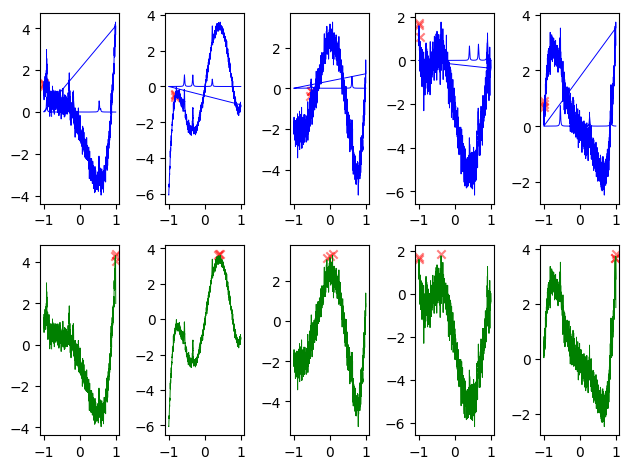

In [28]:
# CLEAN RAYS (using specific spectrum data, before 2nd difference was calculated using entire dataset)
# handle boundary cases & integer-based indexing 
# Basically same as before 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.signal

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id].copy()  # to avoid modifying original DataFrame

    # Cosmic Ray Removal
    # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
    first_difference = np.diff(spectrum_data['Intensity'], n=1)
    second_difference = np.diff(first_difference, n=1)

    # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
    threshold = 2.0 
    cosmic_ray_indices = np.where(second_difference > threshold)[0]

    # Print or inspect cosmic_ray_indices array
    print(f"Cosmic Ray Indices for Spectrum {i}:", cosmic_ray_indices)             
        
    # 3) Replace these points using custom interpolation
    for index in cosmic_ray_indices:
        # Custom interpolation
        left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
        right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

        left_distance = index - left_index
        right_distance = right_index - index

        left_neighbor = spectrum_data.iloc[left_index]['Intensity']
        right_neighbor = spectrum_data.iloc[right_index]['Intensity']

        # Linear interpolation to replace cosmic ray spike
        interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
        original_value = spectrum_data.iloc[index]['Intensity']
        
        print(f"Original Value: {original_value:.4f}, Interpolated Value: {interpolated_value:.4f}")
        
        # Assign the interpolated value to the original spectrum
        spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

    # Drop duplicate entries in 'Wavelength' column
    spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

    # Append cleaned spectrum to the list
    cleaned_spectra.append(spectrum_data)
    
# Plot full synthetic spectra with cosmic rays marked
num_spectra = len(spectrum_ids)
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    plt.subplot(2, num_spectra, i)

    # Plot original spectrum with cosmic rays marked
    plt.plot(df[df['Spectrum_ID'] == spectrum_id]['Wavelength'], 
             df[df['Spectrum_ID'] == spectrum_id]['Intensity'], 
             color='blue', label='Original Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(df[df['Spectrum_ID'] == spectrum_id]['Intensity'].values)

    # Calculate median intensity of identified peaks
    median_intensity = np.median(df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peaks])

    # Set dynamic threshold based on median intensity
    cosmic_ray_threshold = median_intensity * 1.5
    
    # Filter peaks (only above dynamic threshold)
    cosmic_ray_peaks = [peak for peak in peaks if df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak] > cosmic_ray_threshold]

    # Ensure at least 1 & at most 3 cosmic rays
    num_cosmic_rays = min(max(len(cosmic_ray_peaks), 1), 3)

    # Sort cosmic ray peaks by intensity in descending order
    sorted_cosmic_ray_peaks = sorted(cosmic_ray_peaks, key=lambda peak: df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak], reverse=True)

    # Determine number of cosmic rays to mark
    num_cosmic_rays_to_mark = min(num_cosmic_rays, len(sorted_cosmic_ray_peaks))

    # Mark cosmic ray positions with "x" above peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(df[df['Spectrum_ID'] == spectrum_id]['Wavelength'].iloc[peak], 
                    df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak] + 0.10, 
                    marker='x', color='red', alpha=0.5)

# Plot cleaned spectra
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    plt.subplot(2, num_spectra, num_spectra + i)

    # Plot cleaned spectrum looking for rays
    plt.plot(cleaned_spectra[i - 1]['Wavelength'], 
             cleaned_spectra[i - 1]['Intensity'], 
             color='green', label='Cleaned Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima for cleaned spectrum
    peaks_cleaned, _ = scipy.signal.find_peaks(cleaned_spectra[i - 1]['Intensity'].values)

    # Set dynamic threshold based on median intensity
    median_intensity_cleaned = np.median(cleaned_spectra[i - 1]['Intensity'].iloc[peaks_cleaned])
    cosmic_ray_threshold_cleaned = median_intensity_cleaned * 1.5
    
    # Filter peaks (only above dynamic threshold)
    cosmic_ray_peaks_cleaned = [peak for peak in peaks_cleaned if cleaned_spectra[i - 1]['Intensity'].iloc[peak] > cosmic_ray_threshold_cleaned]

    # Ensure at least 1 & at most 3 cosmic rays
    num_cosmic_rays_cleaned = min(max(len(cosmic_ray_peaks_cleaned), 1), 3)

    # Sort cosmic ray peaks by intensity in descending order
    sorted_cosmic_ray_peaks_cleaned = sorted(cosmic_ray_peaks_cleaned, key=lambda peak: cleaned_spectra[i - 1]['Intensity'].iloc[peak], reverse=True)

    # Determine number of cosmic rays to mark
    num_cosmic_rays_to_mark_cleaned = min(num_cosmic_rays_cleaned, len(sorted_cosmic_ray_peaks_cleaned))

    # Mark cosmic ray positions with "x" above peaks
    for peak in sorted_cosmic_ray_peaks_cleaned[:num_cosmic_rays_to_mark_cleaned]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(cleaned_spectra[i - 1]['Wavelength'].iloc[peak], 
                    cleaned_spectra[i - 1]['Intensity'].iloc[peak] + 0.10, 
                    marker='x', color='red', alpha=0.5)

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

Cosmic Ray Indices for Spectrum 1: []
Cosmic Ray Indices for Spectrum 2: []
Cosmic Ray Indices for Spectrum 3: []
Cosmic Ray Indices for Spectrum 4: []
Cosmic Ray Indices for Spectrum 5: []


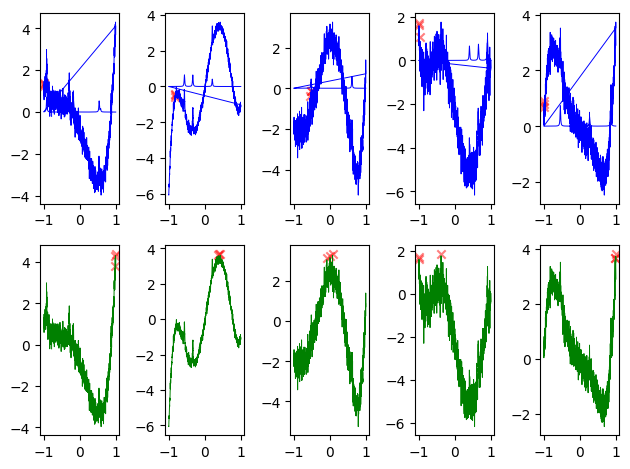

In [29]:
# MEDIAN FILTERING INSTEAD OF 2ND DIFFERENCE (JUST PROBING)
# CLEAN RAYS (using specific spectrum data, before 2nd difference was calculated using entire dataset)
# handle boundary cases & integer-based indexing 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.signal

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id].copy()  # to avoid modifying the original DataFrame

    # Cosmic Ray Removal
    # Use median filtering to identify cosmic rays
    window_size = 5
    median_values = scipy.signal.medfilt(spectrum_data['Intensity'], kernel_size=window_size)
    cosmic_ray_indices = np.where(np.abs(spectrum_data['Intensity'] - median_values) > 2.0)[0]

    # Print or inspect cosmic_ray_indices array
    print(f"Cosmic Ray Indices for Spectrum {i}:", cosmic_ray_indices)             

    # Replace these points using custom interpolation
    for index in cosmic_ray_indices:
        # Custom interpolation
        left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
        right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

        left_distance = index - left_index
        right_distance = right_index - index

        left_neighbor = spectrum_data.iloc[left_index]['Intensity']
        right_neighbor = spectrum_data.iloc[right_index]['Intensity']

        # Linear interpolation to replace cosmic ray spike
        interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
        original_value = spectrum_data.iloc[index]['Intensity']

        print(f"Original Value: {original_value:.4f}, Interpolated Value: {interpolated_value:.4f}")

        # Assign the interpolated value to the original spectrum
        spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

    # Drop duplicate entries in the 'Wavelength' column
    spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

    # Append the cleaned spectrum to the list
    cleaned_spectra.append(spectrum_data)

# Plot full synthetic spectra with cosmic rays marked
num_spectra = len(spectrum_ids)
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    plt.subplot(2, num_spectra, i)

    # Plot the original spectrum with cosmic rays marked
    plt.plot(df[df['Spectrum_ID'] == spectrum_id]['Wavelength'], 
             df[df['Spectrum_ID'] == spectrum_id]['Intensity'], 
             color='blue', label='Original Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(df[df['Spectrum_ID'] == spectrum_id]['Intensity'].values)

    # Calculate the median intensity of identified peaks
    median_intensity = np.median(df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peaks])

    # Set a dynamic threshold based on median intensity
    cosmic_ray_threshold = median_intensity * 1.5

    # Filter peaks (only above the dynamic threshold)
    cosmic_ray_peaks = [peak for peak in peaks if df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak] > cosmic_ray_threshold]

    # Ensure at least 1 & at most 3 cosmic rays
    num_cosmic_rays = min(max(len(cosmic_ray_peaks), 1), 3)

    # Sort cosmic ray peaks by intensity in descending order
    sorted_cosmic_ray_peaks = sorted(cosmic_ray_peaks, key=lambda peak: df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak], reverse=True)

    # Determine the number of cosmic rays to mark
    num_cosmic_rays_to_mark = min(num_cosmic_rays, len(sorted_cosmic_ray_peaks))

    # Mark cosmic ray positions with "x" above peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(df[df['Spectrum_ID'] == spectrum_id]['Wavelength'].iloc[peak], 
                    df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak] + 0.10, 
                    marker='x', color='red', alpha=0.5)

# Plot cleaned spectra
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    plt.subplot(2, num_spectra, num_spectra + i)

    # Plot the cleaned spectrum looking for rays
    plt.plot(cleaned_spectra[i - 1]['Wavelength'], 
             cleaned_spectra[i - 1]['Intensity'], 
             color='green', label='Cleaned Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima for cleaned spectrum
    peaks_cleaned, _ = scipy.signal.find_peaks(cleaned_spectra[i - 1]['Intensity'].values)

    # Set a dynamic threshold based on median intensity
    median_intensity_cleaned = np.median(cleaned_spectra[i - 1]['Intensity'].iloc[peaks_cleaned])
    cosmic_ray_threshold_cleaned = median_intensity_cleaned * 1.5

    # Filter peaks (only above the dynamic threshold)
    cosmic_ray_peaks_cleaned = [peak for peak in peaks_cleaned if cleaned_spectra[i - 1]['Intensity'].iloc[peak] > cosmic_ray_threshold_cleaned]

    # Ensure at least 1 & at most 3 cosmic rays
    num_cosmic_rays_cleaned = min(max(len(cosmic_ray_peaks_cleaned), 1), 3)

    # Sort cosmic ray peaks by intensity in descending order
    sorted_cosmic_ray_peaks_cleaned = sorted(cosmic_ray_peaks_cleaned, key=lambda peak: cleaned_spectra[i - 1]['Intensity'].iloc[peak], reverse=True)

    # Determine the number of cosmic rays to mark
    num_cosmic_rays_to_mark_cleaned = min(num_cosmic_rays_cleaned, len(sorted_cosmic_ray_peaks_cleaned))

    # Mark cosmic ray positions with "x" above peaks
    for peak in sorted_cosmic_ray_peaks_cleaned[:num_cosmic_rays_to_mark_cleaned]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(cleaned_spectra[i - 1]['Wavelength'].iloc[peak], 
                    cleaned_spectra[i - 1]['Intensity'].iloc[peak] + 0.10, 
                    marker='x', color='red', alpha=0.5)

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

Cosmic Ray Indices for Spectrum 1: []
Cosmic Ray Indices for Spectrum 2: []
Cosmic Ray Indices for Spectrum 3: []
Cosmic Ray Indices for Spectrum 4: []
Cosmic Ray Indices for Spectrum 5: []


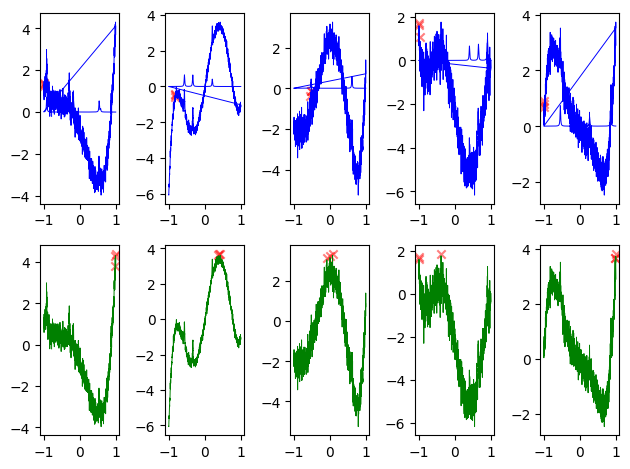

In [31]:
# CHANGING THRESHOLD
# CLEAN RAYS (using specific spectrum data, before 2nd difference was calculated using entire dataset)
# handle boundary cases & integer-based indexing 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.signal

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id].copy()  # to avoid modifying the original DataFrame

    # Cosmic Ray Removal
    # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
    first_difference = np.diff(spectrum_data['Intensity'], n=1)
    second_difference = np.diff(first_difference, n=1)

    # 2) Identify points where the second difference exceeds a dynamic threshold, indicating a cosmic ray spike
    mad_threshold = 1.48 * np.median(np.abs(second_difference - np.median(second_difference)))  # Median Absolute Deviation (MAD) threshold
    cosmic_ray_indices = np.where(np.abs(second_difference) > mad_threshold)[0]

    # Print or inspect cosmic_ray_indices array
    print(f"Cosmic Ray Indices for Spectrum {i}:", cosmic_ray_indices)             

    # 3) Replace these points using custom interpolation
    for index in cosmic_ray_indices:
        # Custom interpolation
        left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
        right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

        left_distance = index - left_index
        right_distance = right_index - index

        left_neighbor = spectrum_data.iloc[left_index]['Intensity']
        right_neighbor = spectrum_data.iloc[right_index]['Intensity']

        # Linear interpolation to replace cosmic ray spike
        interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
        original_value = spectrum_data.iloc[index]['Intensity']

        print(f"Original Value: {original_value:.4f}, Interpolated Value: {interpolated_value:.4f}")

        # Assign the interpolated value to the original spectrum
        spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

    # Drop duplicate entries in the 'Wavelength' column
    spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

    # Append the cleaned spectrum to the list
    cleaned_spectra.append(spectrum_data)

# Plot full synthetic spectra with cosmic rays marked
num_spectra = len(spectrum_ids)
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    plt.subplot(2, num_spectra, i)

    # Plot the original spectrum with cosmic rays marked
    plt.plot(df[df['Spectrum_ID'] == spectrum_id]['Wavelength'], 
             df[df['Spectrum_ID'] == spectrum_id]['Intensity'], 
             color='blue', label='Original Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(df[df['Spectrum_ID'] == spectrum_id]['Intensity'].values)

    # Calculate the median intensity of identified peaks
    median_intensity = np.median(df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peaks])

    # Set a dynamic threshold based on median intensity
    cosmic_ray_threshold = median_intensity * 1.5

    # Filter peaks (only above the dynamic threshold)
    cosmic_ray_peaks = [peak for peak in peaks if df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak] > cosmic_ray_threshold]

    # Ensure at least 1 & at most 3 cosmic rays
    num_cosmic_rays = min(max(len(cosmic_ray_peaks), 1), 3)

    # Sort cosmic ray peaks by intensity in descending order
    sorted_cosmic_ray_peaks = sorted(cosmic_ray_peaks, key=lambda peak: df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak], reverse=True)

    # Determine the number of cosmic rays to mark
    num_cosmic_rays_to_mark = min(num_cosmic_rays, len(sorted_cosmic_ray_peaks))

    # Mark cosmic ray positions with "x" above peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(df[df['Spectrum_ID'] == spectrum_id]['Wavelength'].iloc[peak], 
                    df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak] + 0.10, 
                    marker='x', color='red', alpha=0.5)
        
# Plot cleaned spectra
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    plt.subplot(2, num_spectra, num_spectra + i)

    # Plot cleaned spectrum looking for rays
    plt.plot(cleaned_spectra[i - 1]['Wavelength'], 
             cleaned_spectra[i - 1]['Intensity'], 
             color='green', label='Cleaned Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima for cleaned spectrum
    peaks_cleaned, _ = scipy.signal.find_peaks(cleaned_spectra[i - 1]['Intensity'].values)

    # Set a dynamic threshold based on median intensity
    median_intensity_cleaned = np.median(cleaned_spectra[i - 1]['Intensity'].iloc[peaks_cleaned])
    cosmic_ray_threshold_cleaned = median_intensity_cleaned * 1.5

    # Filter peaks (only above dynamic threshold)
    cosmic_ray_peaks_cleaned = [peak for peak in peaks_cleaned if cleaned_spectra[i - 1]['Intensity'].iloc[peak] > cosmic_ray_threshold_cleaned]

    # Ensure at least 1 & at most 3 cosmic rays
    num_cosmic_rays_cleaned = min(max(len(cosmic_ray_peaks_cleaned), 1), 3)

    # Sort cosmic ray peaks by intensity in descending order
    sorted_cosmic_ray_peaks_cleaned = sorted(cosmic_ray_peaks_cleaned, key=lambda peak: cleaned_spectra[i - 1]['Intensity'].iloc[peak], reverse=True)

    # Determine the number of cosmic rays to mark
    num_cosmic_rays_to_mark_cleaned = min(num_cosmic_rays_cleaned, len(sorted_cosmic_ray_peaks_cleaned))

    # Mark cosmic ray positions with "x" above peaks
    for peak in sorted_cosmic_ray_peaks_cleaned[:num_cosmic_rays_to_mark_cleaned]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(cleaned_spectra[i - 1]['Wavelength'].iloc[peak], 
                    cleaned_spectra[i - 1]['Intensity'].iloc[peak] + 0.10, 
                    marker='x', color='red', alpha=0.5)

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

Cosmic Ray Indices for Spectrum 1: [ 647  726  878 1023]
Original Value: -1.9823, Interpolated Value: -2.9410
Original Value: -2.7076, Interpolated Value: -3.2688
Original Value: -2.5256, Interpolated Value: -2.9369
Original Value: 4.1120, Interpolated Value: 1.9817
Cosmic Ray Indices for Spectrum 2: []
Cosmic Ray Indices for Spectrum 3: [  54  109  138  188  275  549  563  659  792  796  869  915 1006]
Original Value: -1.2600, Interpolated Value: -2.7278
Original Value: -1.6210, Interpolated Value: -2.2318
Original Value: -1.7057, Interpolated Value: -2.5788
Original Value: -1.4340, Interpolated Value: -1.9171
Original Value: -0.2604, Interpolated Value: -1.1307
Original Value: 1.9243, Interpolated Value: 2.1216
Original Value: 2.3256, Interpolated Value: 1.6260
Original Value: 1.6384, Interpolated Value: 0.9504
Original Value: -2.3980, Interpolated Value: -2.5211
Original Value: -1.5306, Interpolated Value: -2.7280
Original Value: -3.3233, Interpolated Value: -4.1440
Original Value: 

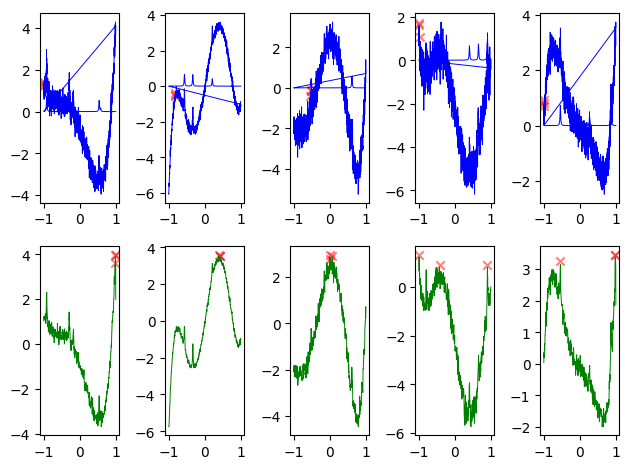

In [32]:
# ADDING MEDIAN FILTER,CONSERVING 2ND DIFFERENCE
# CLEAN RAYS (using specific spectrum data, before 2nd difference was calculated using entire dataset)
# handle boundary cases & integer-based indexing 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.signal

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id].copy()  # to avoid modifying the original DataFrame

    # Cosmic Ray Removal
    # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic rays exceeding predefined threshold)
    first_difference = np.diff(spectrum_data['Intensity'], n=1)
    second_difference = np.diff(first_difference, n=1)

    # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
    threshold = 2.0 
    cosmic_ray_indices = np.where(second_difference > threshold)[0]

    # Print or inspect cosmic_ray_indices array
    print(f"Cosmic Ray Indices for Spectrum {i}:", cosmic_ray_indices)             

    # 3) Replace these points using custom interpolation
    for index in cosmic_ray_indices:
        # Custom interpolation
        left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
        right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

        left_distance = index - left_index
        right_distance = right_index - index

        left_neighbor = spectrum_data.iloc[left_index]['Intensity']
        right_neighbor = spectrum_data.iloc[right_index]['Intensity']

        # Linear interpolation to replace cosmic ray spike
        interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
        original_value = spectrum_data.iloc[index]['Intensity']

        print(f"Original Value: {original_value:.4f}, Interpolated Value: {interpolated_value:.4f}")

        # Assign the interpolated value to the original spectrum
        spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

    # 4) Apply median filtering to smooth out the remaining artifacts
    spectrum_data['Intensity'] = scipy.signal.medfilt(spectrum_data['Intensity'], kernel_size=5)

    # Drop duplicate entries in the 'Wavelength' column
    spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

    # Append the cleaned spectrum to the list
    cleaned_spectra.append(spectrum_data)

# Plot full synthetic spectra with cosmic rays marked
num_spectra = len(spectrum_ids)
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    plt.subplot(2, num_spectra, i)

    # Plot the original spectrum with cosmic rays marked
    plt.plot(df[df['Spectrum_ID'] == spectrum_id]['Wavelength'], 
             df[df['Spectrum_ID'] == spectrum_id]['Intensity'], 
             color='blue', label='Original Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(df[df['Spectrum_ID'] == spectrum_id]['Intensity'].values)

    # Calculate the median intensity of identified peaks
    median_intensity = np.median(df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peaks])

    # Set a dynamic threshold based on median intensity
    cosmic_ray_threshold = median_intensity * 1.5

    # Filter peaks (only above dynamic threshold)
    cosmic_ray_peaks = [peak for peak in peaks if df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak] > cosmic_ray_threshold]

    # Ensure at least 1 & at most 3 cosmic rays
    num_cosmic_rays = min(max(len(cosmic_ray_peaks), 1), 3)

    # Sort cosmic ray peaks by intensity in descending order
    sorted_cosmic_ray_peaks = sorted(cosmic_ray_peaks, key=lambda peak: df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak], reverse=True)

    # Determine the number of cosmic rays to mark
    num_cosmic_rays_to_mark = min(num_cosmic_rays, len(sorted_cosmic_ray_peaks))

    # Mark cosmic ray positions with "x" above peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(df[df['Spectrum_ID'] == spectrum_id]['Wavelength'].iloc[peak], 
                    df[df['Spectrum_ID'] == spectrum_id]['Intensity'].iloc[peak] + 0.10, 
                    marker='x', color='red', alpha=0.5)

# Plot cleaned spectra
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    plt.subplot(2, num_spectra, num_spectra + i)

    # Plot cleaned spectrum looking for rays
    plt.plot(cleaned_spectra[i - 1]['Wavelength'], 
             cleaned_spectra[i - 1]['Intensity'], 
             color='green', label='Cleaned Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima for cleaned spectrum
    peaks_cleaned, _ = scipy.signal.find_peaks(cleaned_spectra[i - 1]['Intensity'].values)

    # Set a dynamic threshold based on median intensity
    median_intensity_cleaned = np.median(cleaned_spectra[i - 1]['Intensity'].iloc[peaks_cleaned])
    cosmic_ray_threshold_cleaned = median_intensity_cleaned * 1.5

    # Filter peaks (only above the dynamic threshold)
    cosmic_ray_peaks_cleaned = [peak for peak in peaks_cleaned if cleaned_spectra[i - 1]['Intensity'].iloc[peak] > cosmic_ray_threshold_cleaned]

    # Ensure at least 1 & at most 3 cosmic rays
    num_cosmic_rays_cleaned = min(max(len(cosmic_ray_peaks_cleaned), 1), 3)

    # Sort cosmic ray peaks by intensity in descending order
    sorted_cosmic_ray_peaks_cleaned = sorted(cosmic_ray_peaks_cleaned, key=lambda peak: cleaned_spectra[i - 1]['Intensity'].iloc[peak], reverse=True)

    # Determine the number of cosmic rays to mark
    num_cosmic_rays_to_mark_cleaned = min(num_cosmic_rays_cleaned, len(sorted_cosmic_ray_peaks_cleaned))

    # Mark cosmic ray positions with "x" above peaks
    for peak in sorted_cosmic_ray_peaks_cleaned[:num_cosmic_rays_to_mark_cleaned]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(cleaned_spectra[i - 1]['Wavelength'].iloc[peak], 
                    cleaned_spectra[i - 1]['Intensity'].iloc[peak] + 0.10, 
                    marker='x', color='red', alpha=0.5)

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

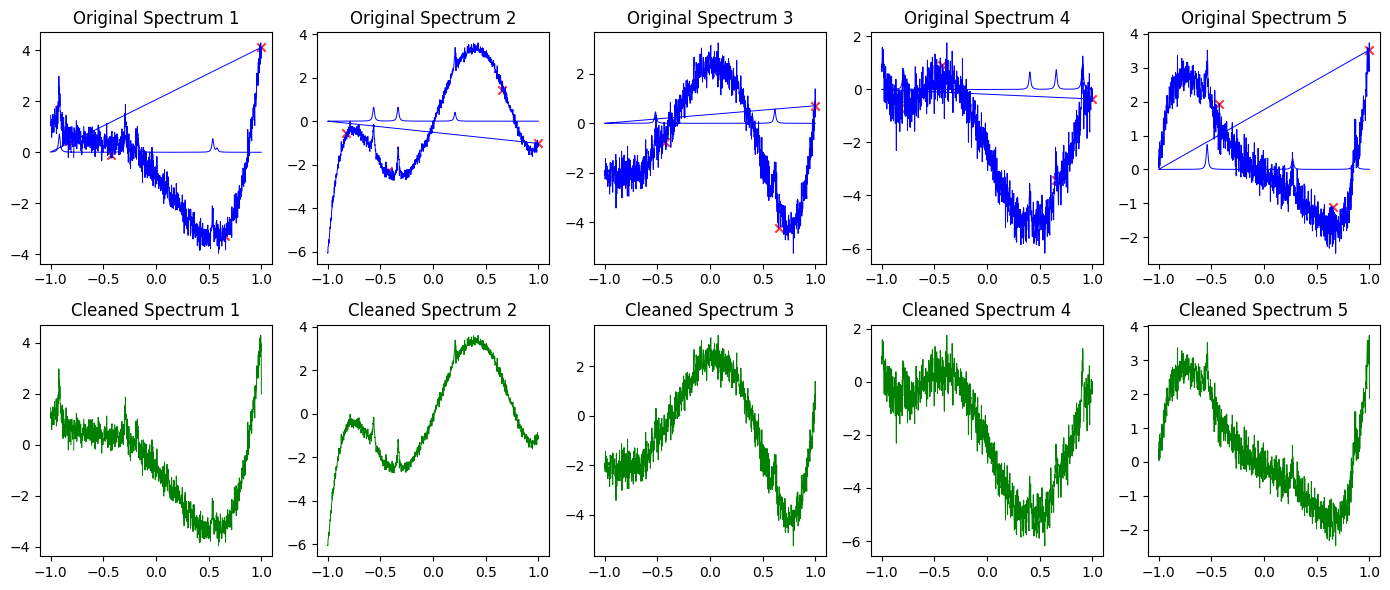

Value at index 89: 2.2287947166422826
Value at index 294: 2.669198537565355
Value at index 845: 2.087612186405707


In [33]:
# LAST TRY WITHOUT IMPROVEMENT
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i, spectrum_id in enumerate(spectrum_ids, start=1):
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id]

    # Cosmic Ray Removal
    if not spectrum_data.empty:
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(spectrum_data['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 2.0 
        cosmic_ray_indices = np.where(second_difference > threshold)[0]

        # 3) Replace these points using linear interpolation
        for index in cosmic_ray_indices:
            left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
            right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

            left_distance = index - left_index
            right_distance = right_index - index

            left_neighbor = spectrum_data.iloc[left_index]['Intensity']
            right_neighbor = spectrum_data.iloc[right_index]['Intensity']

            # Linear interpolation to replace cosmic ray spike
            interpolated_value = left_neighbor + (right_neighbor - left_neighbor) * left_distance / (left_distance + right_distance)
            spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

        # Drop duplicate entries in the 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append cleaned spectrum to list
        cleaned_spectra.append(spectrum_data)

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create output directory
output_directory = 'output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Plot full synthetic spectra with cosmic rays marked
plt.figure(figsize=(14, 6))

for i, spectrum_id in enumerate(spectrum_ids, start=1):
    plt.subplot(2, len(spectrum_ids), i)

    original_spectrum = df[df['Spectrum_ID'] == spectrum_id]
    plt.plot(original_spectrum['Wavelength'], original_spectrum['Intensity'], color='blue', label='Original', linewidth=0.7)
    plt.scatter(original_spectrum['Wavelength'].iloc[cosmic_ray_indices], original_spectrum['Intensity'].iloc[cosmic_ray_indices], marker='x', color='red', alpha=0.8)
    plt.title(f'Original Spectrum {i}')

    plt.subplot(2, len(spectrum_ids), i + len(spectrum_ids))

    cleaned_spectrum = data_cleaned[data_cleaned['Spectrum_ID'] == spectrum_id]
    plt.plot(cleaned_spectrum['Wavelength'], cleaned_spectrum['Intensity'], color='green', label='Cleaned', linewidth=0.7)
    plt.title(f'Cleaned Spectrum {i}')

plt.tight_layout()
plt.show()

# Print values at some cosmic ray indices for analysis
for index in cosmic_ray_indices[:3]:
    value_at_index = second_difference[index]
    print(f"Value at index {index}: {value_at_index}")

Cosmic Ray Indices for Spectrum 1: [ 647  726  878 1023]
Cosmic Ray Indices for Spectrum 2: []
Cosmic Ray Indices for Spectrum 3: [  54  109  138  188  275  549  563  659  792  796  869  915 1006]
Cosmic Ray Indices for Spectrum 4: [ 11  38  70  98 159 163 217 222 254 270 275 295 303 319 322 345 392 416
 420 435 463 553 571 600 643 654 675 687 750 791 844 902 943 956 959 980
 990 996]
Cosmic Ray Indices for Spectrum 5: [  89  294  845 1023]


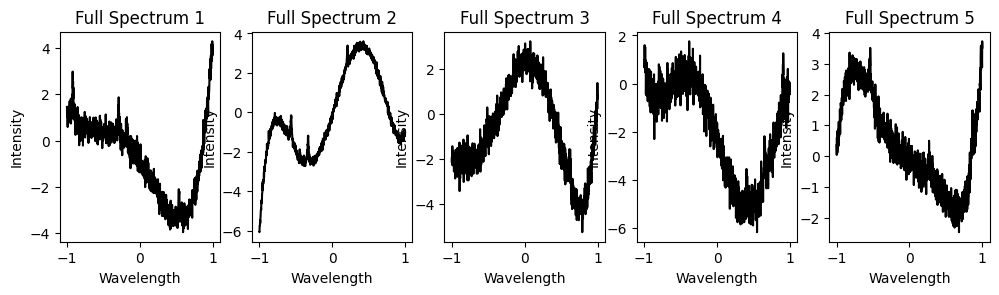

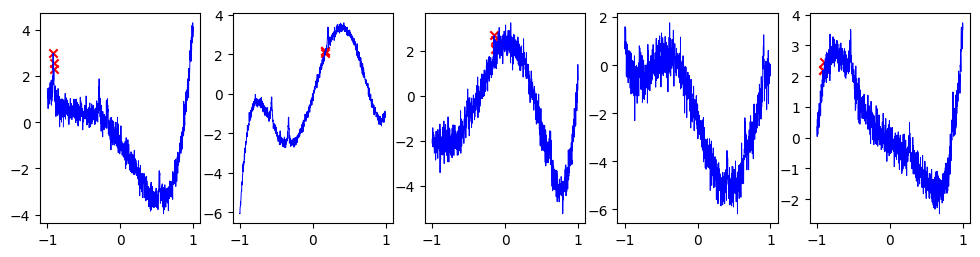

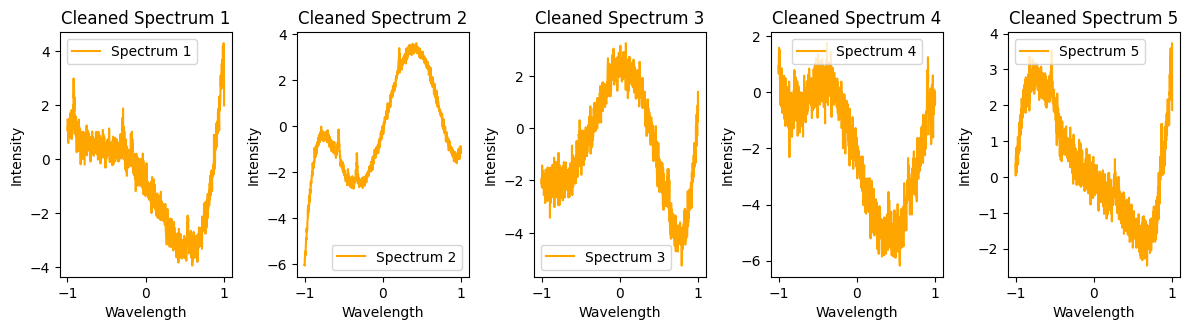

Value at index 89: 2.2287947166422826
Value at index 294: 2.669198537565355
Value at index 845: 2.087612186405707


In [34]:
# VERSION BEFORE NEW MODIFICATIONS, (less resolution)

# CLEAN RAYS (using specific spectrum data, before 2nd difference was calculated using entire dataset)
# handle boundary cases & integer-based indexing 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Extract individual spectra
for spectrum_id in spectrum_ids:
    # Filter data for current spectrum ID
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id]

    # Extract wavelength & intensity data
    wavelength = spectrum_data['Wavelength']
    intensity = spectrum_data['Intensity']

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id]  # df instead of data

    # Check if spectrum exists in data
    if not spectrum_data.empty:

        # Cosmic Ray Removal
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(spectrum_data['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 2.0 
        cosmic_ray_indices = np.where(second_difference > threshold)[0]

        # Print or inspect cosmic_ray_indices array
        print(f"Cosmic Ray Indices for Spectrum {i + 1}:", cosmic_ray_indices)             
        
        # 3) Replace these points using custom interpolation
        for index in cosmic_ray_indices:
            # Custom interpolation
            left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
            right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

            left_distance = index - left_index
            right_distance = right_index - index

            left_neighbor = spectrum_data.iloc[left_index]['Intensity']
            right_neighbor = spectrum_data.iloc[right_index]['Intensity']

            # Linear interpolation to replace cosmic ray spike
            interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
            spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

        # Drop duplicate entries in the 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append the cleaned spectrum to the list
        cleaned_spectra.append(spectrum_data)

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create output directory
output_directory = '/kaggle/working/output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Plot full synthetic spectra
plt.figure(figsize=(12, 6))
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='black')
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    
plt.figure(figsize=(12, 6))
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)

    # Plot with a smoother line & more data points
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='blue', label='Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(synthetic_data_generator.full_spectra_list[i])

    # Set a threshold to distinguish cosmic rays from other peaks
    cosmic_ray_threshold = 2.0

    # Filter peaks (only include those above threshold)
    cosmic_ray_peaks = [peak for peak in peaks if synthetic_data_generator.full_spectra_list[i][peak] > cosmic_ray_threshold]
     
    # Mark cosmic ray positions with "x" above peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(synthetic_data_generator.wavelengths[peak], synthetic_data_generator.full_spectra_list[i][peak] + 0.01, marker='x', color='red')

# Plot cleaned spectra
plt.figure(figsize=(12, 6))
for i, spectrum_data in enumerate(cleaned_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Intensity'], color='orange', label=f'Spectrum {i + 1}')
    plt.title(f'Cleaned Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

# Print values at some cosmic ray indices for analysis
for index in cosmic_ray_indices[:3]: 
    value_at_index = second_difference[index]
    print(f"Value at index {index}: {value_at_index}")

Cosmic Ray Indices for Spectrum 1: [ 647  726  878 1023]
Cosmic Ray Indices for Spectrum 2: []
Cosmic Ray Indices for Spectrum 3: [  54  109  138  188  275  549  563  659  792  796  869  915 1006]
Cosmic Ray Indices for Spectrum 4: [ 11  38  70  98 159 163 217 222 254 270 275 295 303 319 322 345 392 416
 420 435 463 553 571 600 643 654 675 687 750 791 844 902 943 956 959 980
 990 996]
Cosmic Ray Indices for Spectrum 5: [  89  294  845 1023]


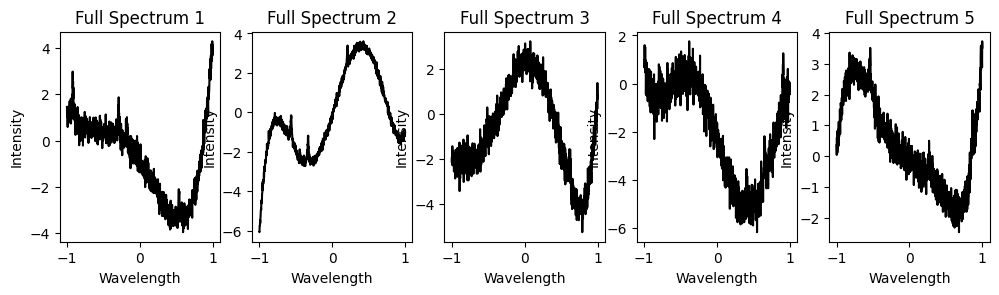

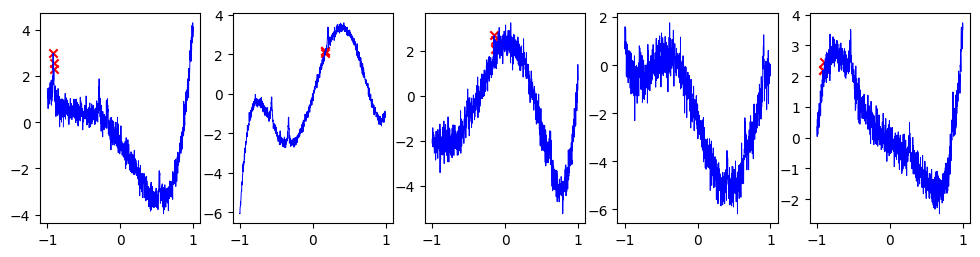

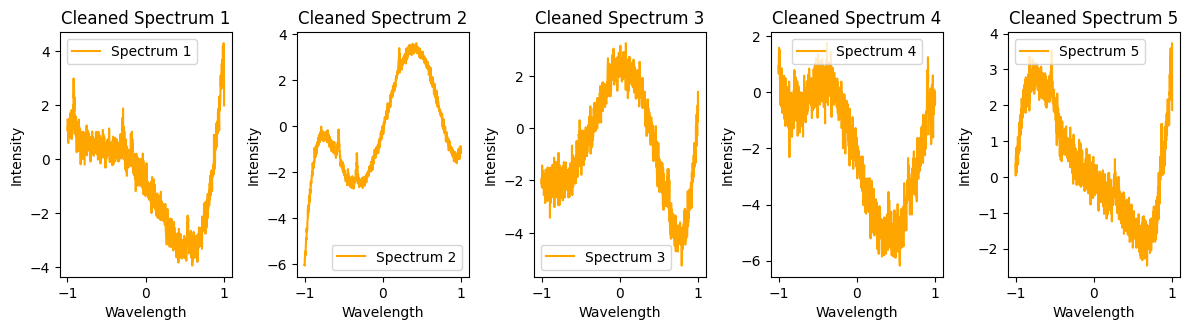

Value at index 89: 2.2287947166422826
Value at index 294: 2.669198537565355
Value at index 845: 2.087612186405707


In [35]:
# VERSION Before big changes, less resolution
# CLEAN RAYS (using specific spectrum data, before 2nd difference was calculated using entire dataset)
# handle boundary cases & integer-based indexing 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Extract individual spectra
for spectrum_id in spectrum_ids:
    # Filter data for current spectrum ID
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id]

    # Extract wavelength & intensity data
    wavelength = spectrum_data['Wavelength']
    intensity = spectrum_data['Intensity']

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id]  # df instead of data

    # Check if spectrum exists in data
    if not spectrum_data.empty:

        # Cosmic Ray Removal
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(spectrum_data['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 2.0 
        cosmic_ray_indices = np.where(second_difference > threshold)[0]

        # Print or inspect cosmic_ray_indices array
        print(f"Cosmic Ray Indices for Spectrum {i + 1}:", cosmic_ray_indices)             
        
        # 3) Replace these points using custom interpolation
        for index in cosmic_ray_indices:
            # Custom interpolation
            left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
            right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

            left_distance = index - left_index
            right_distance = right_index - index

            left_neighbor = spectrum_data.iloc[left_index]['Intensity']
            right_neighbor = spectrum_data.iloc[right_index]['Intensity']

            # Linear interpolation to replace cosmic ray spike
            interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
            spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

        # Drop duplicate entries in the 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append the cleaned spectrum to the list
        cleaned_spectra.append(spectrum_data)

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create output directory
output_directory = '/kaggle/working/output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Plot full synthetic spectra
plt.figure(figsize=(12, 6))
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='black')
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    
plt.figure(figsize=(12, 6))
for i in range(num_spectra):
    plt.subplot(2, num_spectra, i + 1)

    # Plot with a smoother line & more data points
    plt.plot(synthetic_data_generator.wavelengths, synthetic_data_generator.full_spectra_list[i], color='blue', label='Spectrum', linewidth=0.7)

    # Identify cosmic ray positions based on local maxima
    peaks, _ = scipy.signal.find_peaks(synthetic_data_generator.full_spectra_list[i])

    # Set a threshold to distinguish cosmic rays from other peaks
    cosmic_ray_threshold = 2.0

    # Filter peaks (only include those above threshold)
    cosmic_ray_peaks = [peak for peak in peaks if synthetic_data_generator.full_spectra_list[i][peak] > cosmic_ray_threshold]
     
    # Mark cosmic ray positions with "x" above peaks
    for peak in cosmic_ray_peaks[:num_cosmic_rays_to_mark]:
        # Mark cosmic ray with "x" above peak
        plt.scatter(synthetic_data_generator.wavelengths[peak], synthetic_data_generator.full_spectra_list[i][peak] + 0.01, marker='x', color='red')

# Plot cleaned spectra
plt.figure(figsize=(12, 6))
for i, spectrum_data in enumerate(cleaned_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Intensity'], color='orange', label=f'Spectrum {i + 1}')
    plt.title(f'Cleaned Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

# Print values at some cosmic ray indices for analysis
for index in cosmic_ray_indices[:3]: 
    value_at_index = second_difference[index]
    print(f"Value at index {index}: {value_at_index}")

In [39]:
# DEBBUGED VERSION (WHY DOES NOT WORK???) :( 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy  # Make sure to import scipy

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id].copy()  # copy to avoid modifying the original DataFrame

    # Check if spectrum exists in data
    if not spectrum_data.empty:
        # Cosmic Ray Removal
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(spectrum_data['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 2.0 
        cosmic_ray_indices = np.where(second_difference > threshold)[0]

        # Print or inspect cosmic_ray_indices array
        print(f"Cosmic Ray Indices for Spectrum {i + 1}:", cosmic_ray_indices)

        # Print some values before cleaning
        print(f"Before Cleaning - Spectrum {i + 1}:")
        print(spectrum_data['Intensity'].head())

        # 3) Replace these points using custom interpolation
        for index in cosmic_ray_indices:
            # Custom interpolation
            left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
            right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

            left_distance = index - left_index
            right_distance = right_index - index

            left_neighbor = spectrum_data.iloc[left_index]['Intensity']
            right_neighbor = spectrum_data.iloc[right_index]['Intensity']

            # Linear interpolation to replace cosmic ray spike
            interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
            spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

        # Drop duplicate entries in the 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append the cleaned spectrum to the list
        cleaned_spectra.append(spectrum_data)

        # Print some values after cleaning
        print(f"After Cleaning - Spectrum {i + 1}:")
        print(spectrum_data['Intensity'].head())

# Combine all cleaned spectra into a single DataFrame
data_cleaned = pd.concat(cleaned_spectra)

# Create output directory
output_directory = '/kaggle/working/output'
os.makedirs(output_directory, exist_ok=True)

# Save DataFrame
output_file_path = os.path.join(output_directory, 'cleaned_spectra.csv')
data_cleaned.to_csv(output_file_path, index=False)

# Plot full synthetic spectra
plt.figure(figsize=(12, 6))
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id], color='blue'

    plt.subplot(2, num_spectra, i + 1)
    plt.plot(spectrum_data['Wavelength'], spectrum_data['Intensity'], color='green')
    plt.title(f'Full Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Plot cleaned spectra
plt.figure(figsize=(12, 6))
for i, cleaned_spectrum_data in enumerate(cleaned_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(cleaned_spectrum_data['Wavelength'], cleaned_spectrum_data['Intensity'], color='red', label=f'Spectrum {i + 1}')
    plt.title(f'Cleaned Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

Cosmic Ray Indices for Spectrum 1: [ 647  726  878 1023]
Before Cleaning - Spectrum 1:
0    1.449335
1    1.034044
2    1.192852
3    1.227842
4    1.162717
Name: Intensity, dtype: float64
After Cleaning - Spectrum 1:
0    1.449335
1    1.034044
2    1.192852
3    1.227842
4    1.162717
Name: Intensity, dtype: float64
Cosmic Ray Indices for Spectrum 2: []
Before Cleaning - Spectrum 2:
2048   -6.056245
2049   -6.073964
2050   -5.755042
2051   -5.752230
2052   -5.714797
Name: Intensity, dtype: float64
After Cleaning - Spectrum 2:
2048   -6.056245
2049   -6.073964
2050   -5.755042
2051   -5.752230
2052   -5.714797
Name: Intensity, dtype: float64
Cosmic Ray Indices for Spectrum 3: [  54  109  138  188  275  549  563  659  792  796  869  915 1006]
Before Cleaning - Spectrum 3:
4096   -2.105957
4097   -1.906036
4098   -2.256544
4099   -2.176653
4100   -1.424939
Name: Intensity, dtype: float64
After Cleaning - Spectrum 3:
4096   -2.105957
4097   -1.906036
4098   -2.256544
4099   -2.176653
410

ValueError: too many values to unpack (expected 2)

<Figure size 1200x600 with 0 Axes>

Left index: 646, Right index: 648, Length: 1024
Left index: 725, Right index: 727, Length: 1024
Left index: 877, Right index: 879, Length: 1024
Left index: 53, Right index: 55, Length: 1024
KeyError at index 54. Skipping...
Left index: 108, Right index: 110, Length: 1024
KeyError at index 109. Skipping...
Left index: 137, Right index: 139, Length: 1024
KeyError at index 138. Skipping...
Left index: 187, Right index: 189, Length: 1024
KeyError at index 188. Skipping...
Left index: 274, Right index: 276, Length: 1024
KeyError at index 275. Skipping...
Left index: 548, Right index: 550, Length: 1024
KeyError at index 549. Skipping...
Left index: 562, Right index: 564, Length: 1024
KeyError at index 563. Skipping...
Left index: 658, Right index: 660, Length: 1024
KeyError at index 659. Skipping...
Left index: 791, Right index: 793, Length: 1024
KeyError at index 792. Skipping...
Left index: 795, Right index: 797, Length: 1024
KeyError at index 796. Skipping...
Left index: 868, Right index:

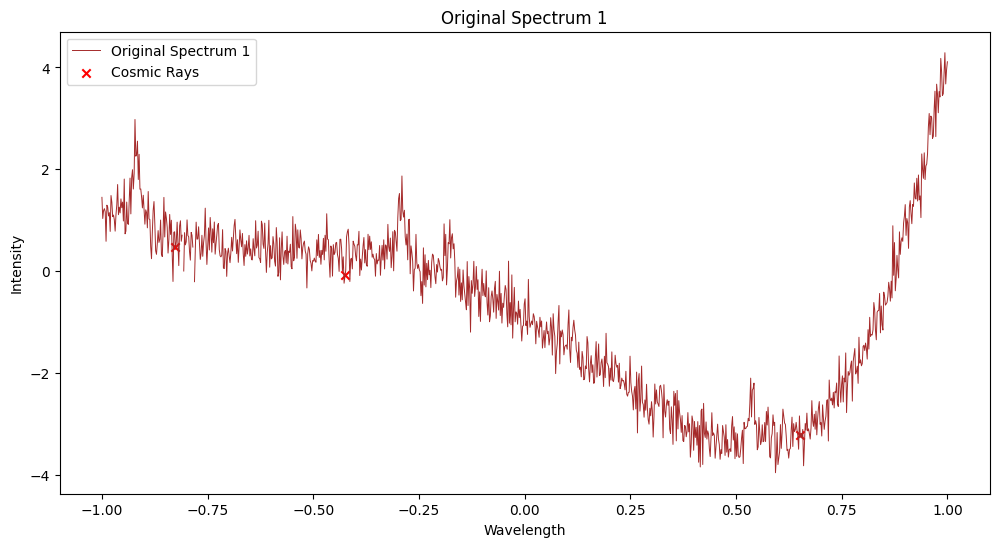

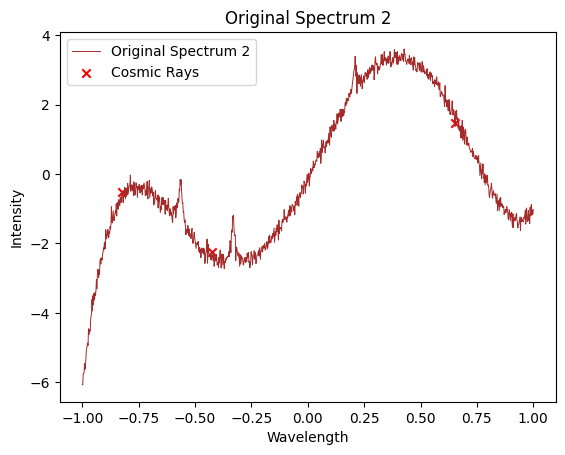

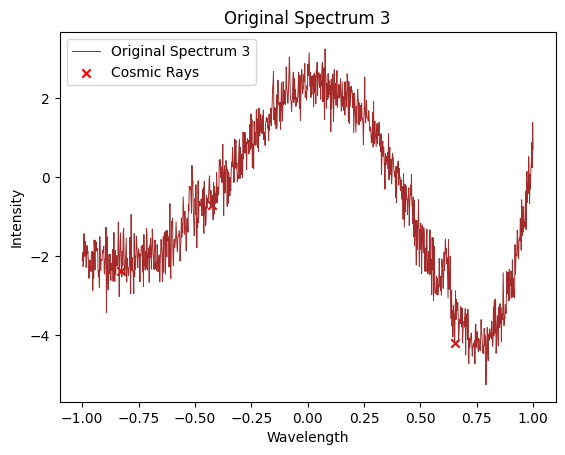

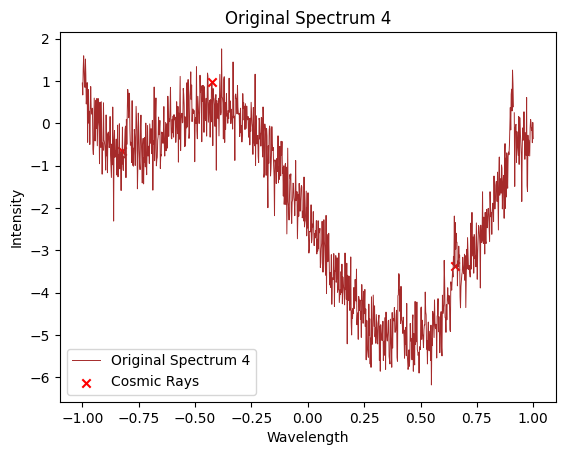

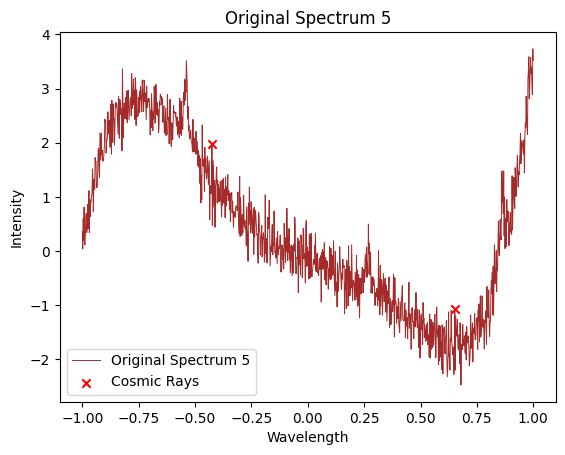

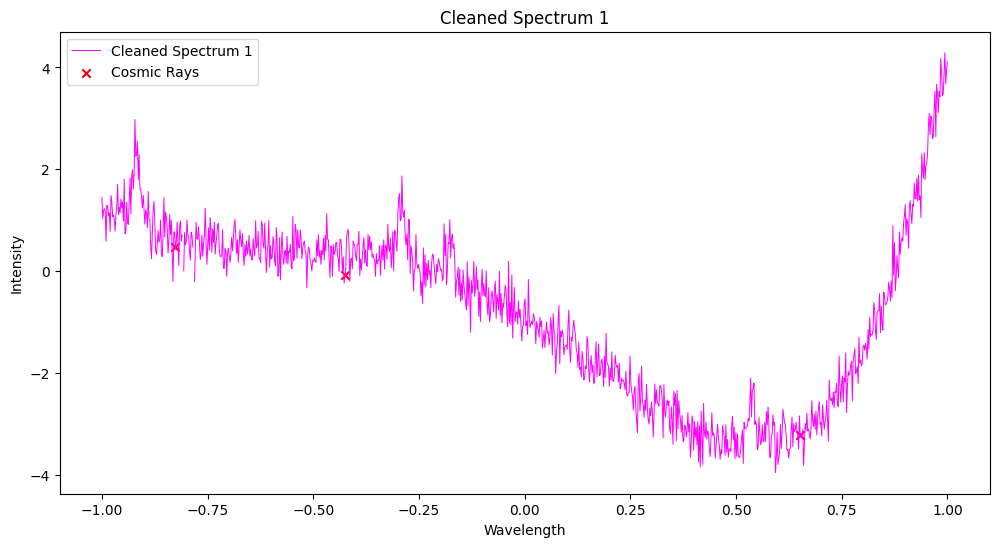

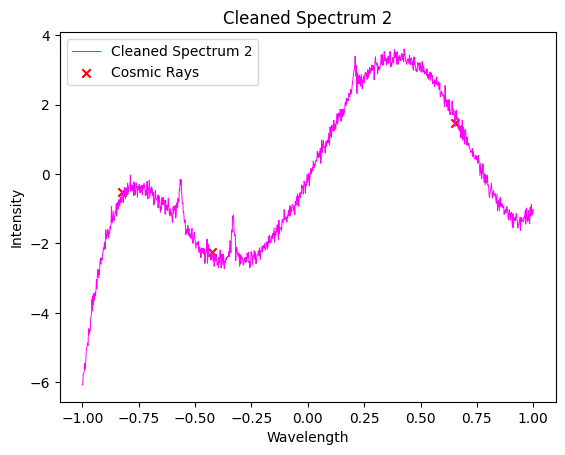

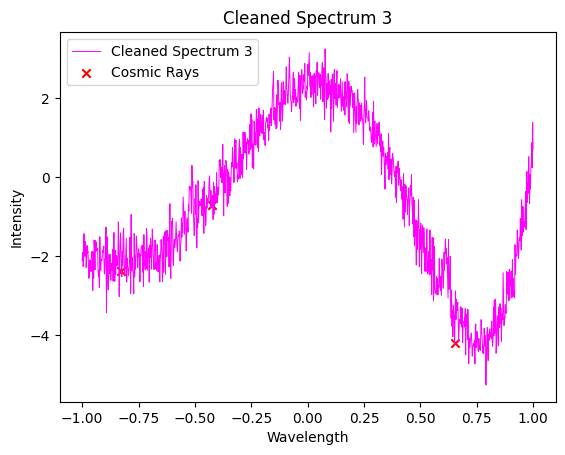

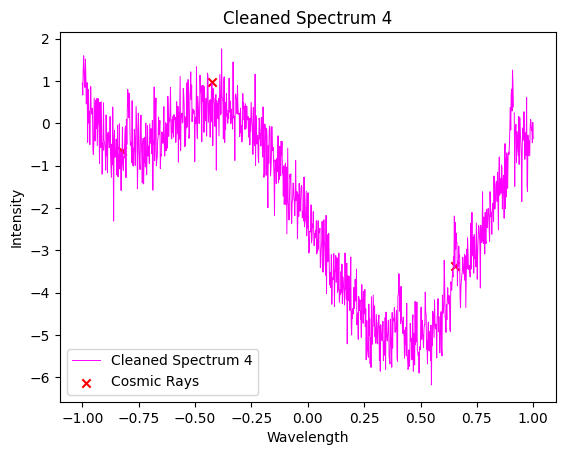

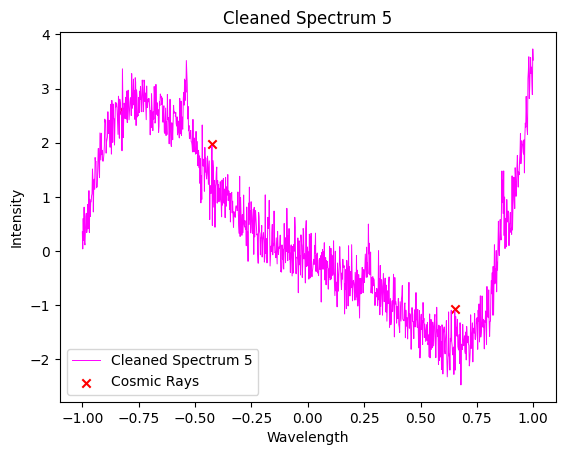

In [88]:
# NEW DEBUGGING PART (AT METHOD)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Create a list to store original spectra
original_spectra = []

# Iterate over all spectra
for i in range(len(spectrum_ids)):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id].copy()

    # Check if spectrum exists in data
    if not spectrum_data.empty:
        # Drop duplicate entries in the 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append the original spectrum to the list
        original_spectra.append(spectrum_data.copy())  # copy to avoid modifying the original data

        # Cosmic Ray Removal
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(spectrum_data['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 2.0
        cosmic_ray_indices = np.where(second_difference > threshold)[0]

        # 3) Replace these points using custom interpolation
        # Inside the for loop for cosmic_ray_indices
        for index in cosmic_ray_indices:
            # Custom interpolation
            left_index = int(np.clip(index - 1, 0, len(spectrum_data) - 1))
            right_index = int(np.clip(index + 1, 0, len(spectrum_data) - 1))

            print(f"Left index: {left_index}, Right index: {right_index}, Length: {len(spectrum_data)}")  # Add this line

            if left_index < 0 or right_index >= len(spectrum_data):
                print("Invalid index detected. Skipping...")
                continue

            try:
                left_distance = index - left_index
                right_distance = right_index - index

                left_neighbor = spectrum_data.at[left_index, 'Intensity']
                right_neighbor = spectrum_data.at[right_index, 'Intensity']

                # Linear interpolation to replace cosmic ray spike
                interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
                spectrum_data.at[index, 'Intensity'] = interpolated_value
            
            except KeyError:
                print(f"KeyError at index {index}. Skipping...")
                continue

        # Drop duplicate entries in the 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append the cleaned spectrum to the list
        cleaned_spectra.append(spectrum_data)

# Plot original spectra with cosmic rays marked
plt.figure(figsize=(12, 6))
for i, original_spectrum_data in enumerate(original_spectra):
    original_spectrum_data = original_spectrum_data.reset_index(drop=True)  # Reset index to default integer index
    plt.plot(original_spectrum_data['Wavelength'], original_spectrum_data['Intensity'], color='brown', label=f'Original Spectrum {i + 1}', linewidth=0.7)
    plt.scatter(original_spectrum_data['Wavelength'].iloc[cosmic_ray_indices], original_spectrum_data['Intensity'].iloc[cosmic_ray_indices] + 0.04, marker='x', color='red', label='Cosmic Rays')
    plt.title(f'Original Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

# Plot cleaned spectra
plt.figure(figsize=(12, 6))
for i, cleaned_spectrum_data in enumerate(cleaned_spectra):
    cleaned_spectrum_data = cleaned_spectrum_data.reset_index(drop=True)  # Reset index to default integer index
    plt.plot(cleaned_spectrum_data['Wavelength'], cleaned_spectrum_data['Intensity'], color='magenta', label=f'Cleaned Spectrum {i + 1}', linewidth=0.7)
    plt.scatter(cleaned_spectrum_data['Wavelength'][cosmic_ray_indices], cleaned_spectrum_data['Intensity'][cosmic_ray_indices] + 0.04, marker='x', color='red', label='Cosmic Rays')
    plt.title(f'Cleaned Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

Cosmic Ray Indices for Spectrum 1: [ 647  726  878 1023]
Cosmic Ray Indices for Spectrum 2: []
Cosmic Ray Indices for Spectrum 3: [  54  109  138  188  275  549  563  659  792  796  869  915 1006]
Cosmic Ray Indices for Spectrum 4: [ 11  38  70  98 159 163 217 222 254 270 275 295 303 319 322 345 392 416
 420 435 463 553 571 600 643 654 675 687 750 791 844 902 943 956 959 980
 990 996]
Cosmic Ray Indices for Spectrum 5: [  89  294  845 1023]


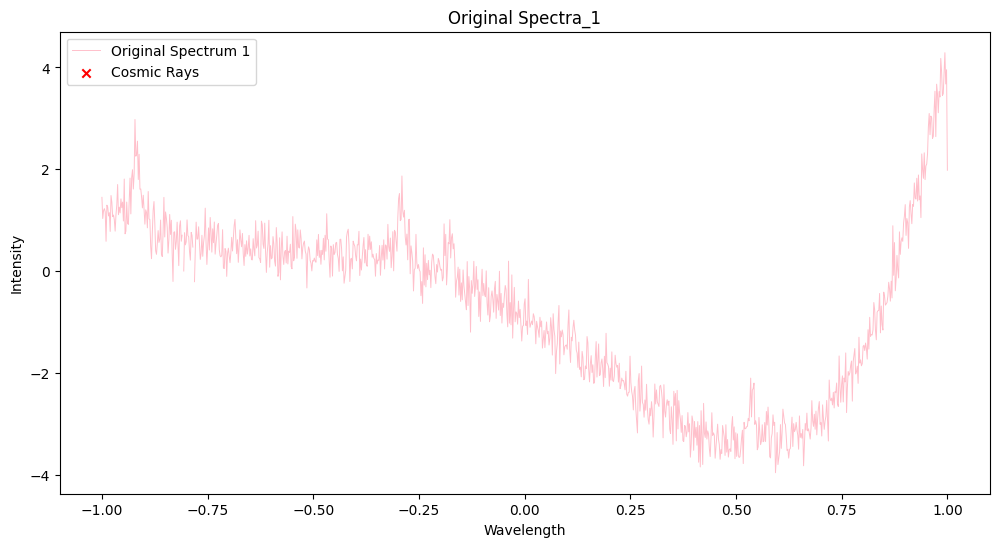

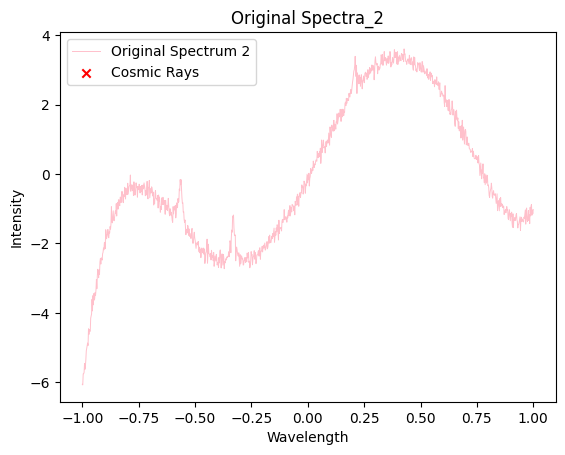

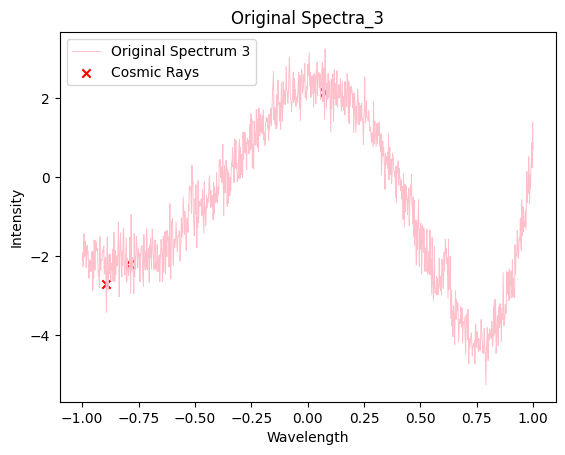

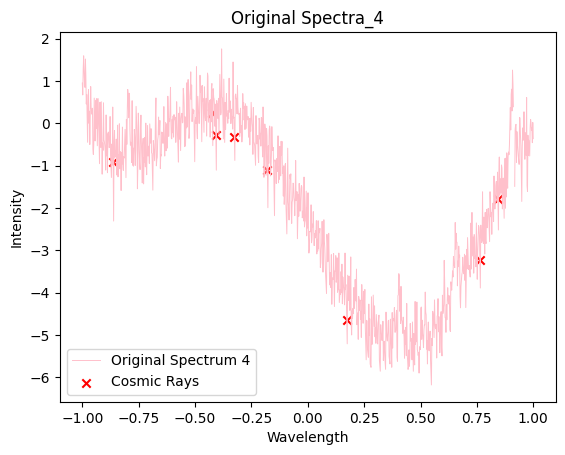

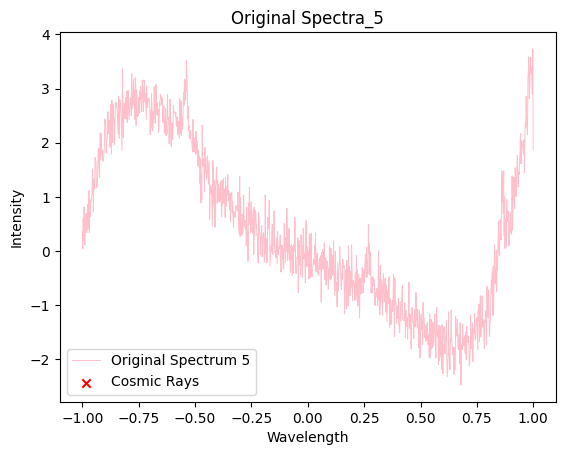

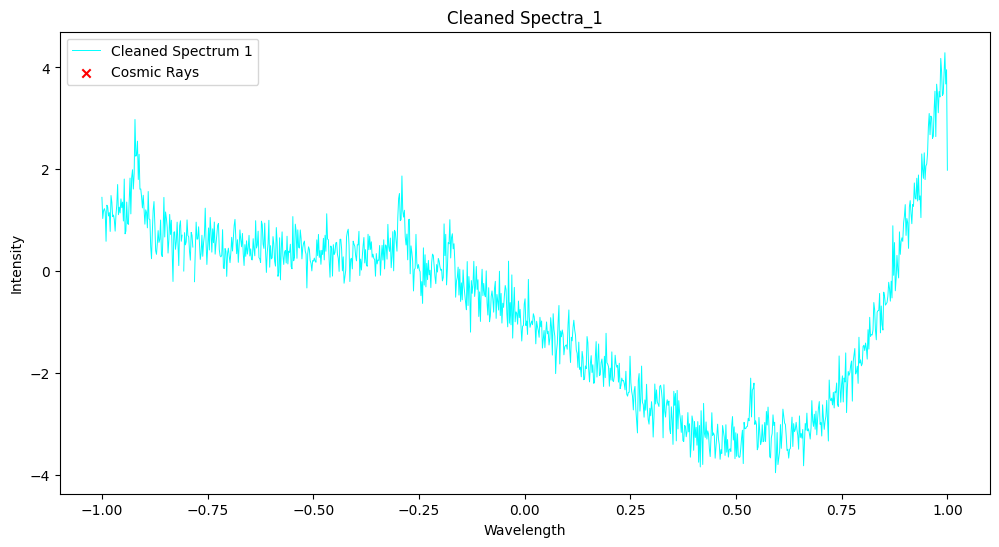

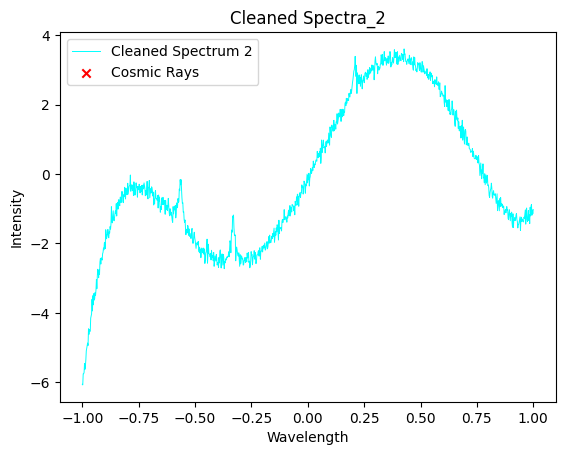

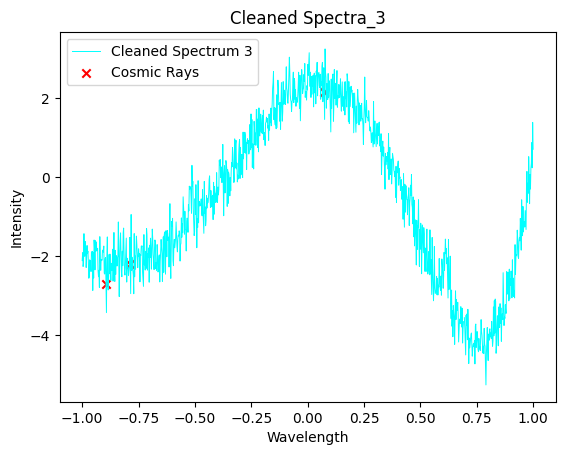

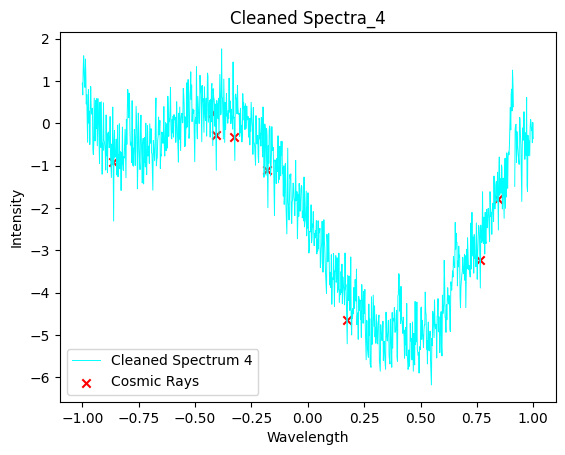

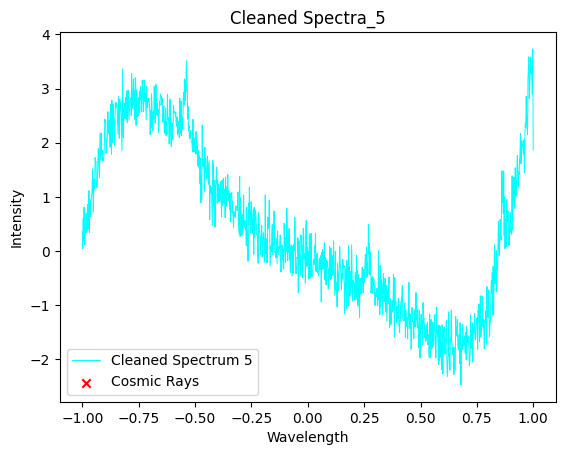

In [83]:
# NEW DEBUGGING PART (ILOC METHOD)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
num_spectra = len(spectrum_ids)
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id].copy()  # df instead of data and make a copy

    # Check if spectrum exists in data
    if not spectrum_data.empty:
        # Cosmic Ray Removal
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(spectrum_data['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 2.0
        cosmic_ray_indices = np.where(second_difference > threshold)[0]

        # Print or inspect cosmic_ray_indices array
        print(f"Cosmic Ray Indices for Spectrum {i + 1}:", cosmic_ray_indices)

        # 3) Replace these points using custom interpolation
        for index in cosmic_ray_indices:
            # Custom interpolation
            left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
            right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

            left_distance = index - left_index
            right_distance = right_index - index

            left_neighbor = spectrum_data['Intensity'].iloc[left_index]
            right_neighbor = spectrum_data['Intensity'].iloc[right_index]

            # Linear interpolation to replace cosmic ray spike
            interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
            spectrum_data.at[spectrum_data.index[index], 'Intensity'] = interpolated_value  # updated index

        # Drop duplicate entries in the 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append the cleaned spectrum to the list
        cleaned_spectra.append(spectrum_data)

# Plot original spectra with cosmic rays marked
plt.figure(figsize=(12, 6))
for i, original_spectrum_data in enumerate(cleaned_spectra):
    cosmic_ray_indices = np.where(np.diff(original_spectrum_data['Intensity'], n=2) > threshold)[0]
    
    plt.plot(original_spectrum_data['Wavelength'], original_spectrum_data['Intensity'], color='pink', label=f'Original Spectrum {i + 1}', linewidth=0.7)
    plt.scatter(original_spectrum_data['Wavelength'].iloc[cosmic_ray_indices], original_spectrum_data['Intensity'].iloc[cosmic_ray_indices] + 0.04, marker='x', color='red', label='Cosmic Rays')
    plt.title(f'Original Spectra_{i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

# Plot cleaned spectra
plt.figure(figsize=(12, 6))
for i, cleaned_spectrum_data in enumerate(cleaned_spectra):
    cosmic_ray_indices = np.where(np.diff(cleaned_spectrum_data['Intensity'], n=2) > threshold)[0]
    
    plt.plot(cleaned_spectrum_data['Wavelength'], cleaned_spectrum_data['Intensity'], color='cyan', label=f'Cleaned Spectrum {i + 1}', linewidth=0.7)
    plt.scatter(cleaned_spectrum_data['Wavelength'].iloc[cosmic_ray_indices], cleaned_spectrum_data['Intensity'].iloc[cosmic_ray_indices] + 0.04, marker='x', color='red', label='Cosmic Rays')
    plt.title(f'Cleaned Spectra_{i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

Cosmic Ray Indices for Spectrum 1: []
Cosmic Ray Indices for Spectrum 2: []
Cosmic Ray Indices for Spectrum 3: []
Cosmic Ray Indices for Spectrum 4: []
Cosmic Ray Indices for Spectrum 5: []


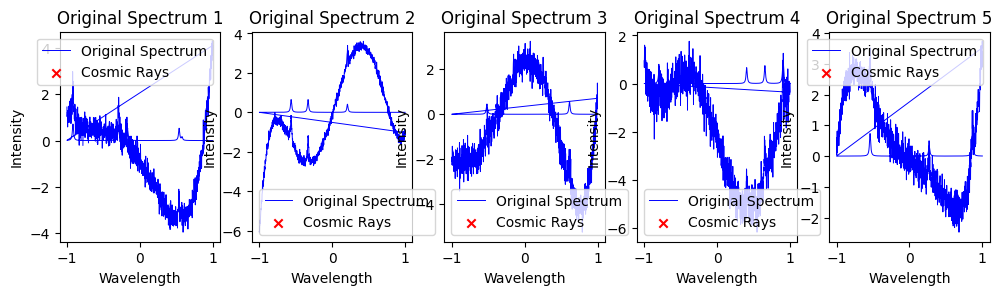

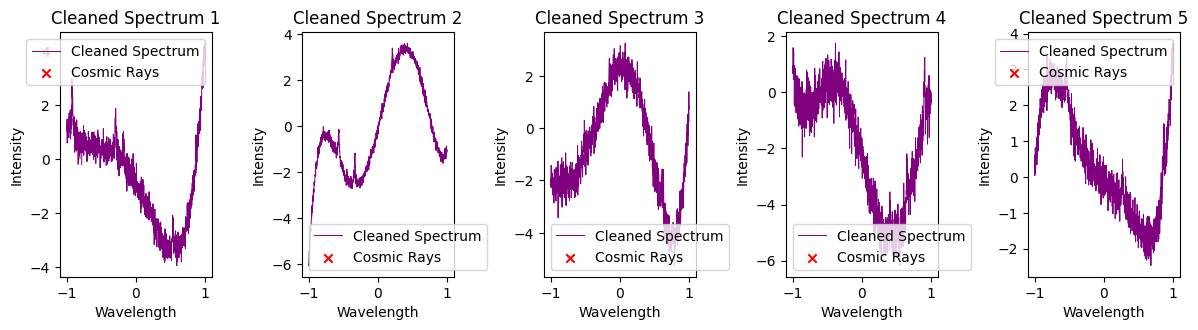

In [46]:
#  AFTER DEBUGGING (hopping it run) :/
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Initialize a list to store original spectra
original_spectra = []

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id].copy()  # df instead of data and make a copy

    # Check if spectrum exists in data
    if not spectrum_data.empty:
        # Append the original spectrum to the list
        original_spectra.append(spectrum_data)

        # Cosmic Ray Removal
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(spectrum_data['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 5.0
        cosmic_ray_indices = np.where(second_difference > threshold)[0]

        # Print or inspect cosmic_ray_indices array
        print(f"Cosmic Ray Indices for Spectrum {i + 1}:", cosmic_ray_indices)

        # 3) Replace these points using custom interpolation
        for index in cosmic_ray_indices:
            # Custom interpolation
            left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
            right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

            left_distance = index - left_index
            right_distance = right_index - index

            left_neighbor = spectrum_data.iloc[left_index]['Intensity']
            right_neighbor = spectrum_data.iloc[right_index]['Intensity']

            # Linear interpolation to replace cosmic ray spike
            interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
            spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

        # Drop duplicate entries in the 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append the cleaned spectrum to the list
        cleaned_spectra.append(spectrum_data)

# Plot original spectra with cosmic rays marked
plt.figure(figsize=(12, 6))
for i, original_spectrum_data in enumerate(original_spectra):
    cosmic_ray_indices_original = np.where(second_difference > threshold)[0]  # separate indices for original spectra
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(original_spectrum_data['Wavelength'], original_spectrum_data['Intensity'], color='blue', label='Original Spectrum', linewidth=0.7)
    plt.scatter(original_spectrum_data['Wavelength'].iloc[cosmic_ray_indices_original.tolist()], original_spectrum_data['Intensity'].iloc[cosmic_ray_indices_original.tolist()] + 0.04, marker='x', color='red', label='Cosmic Rays')
    plt.title(f'Original Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

# Plot cleaned spectra
plt.figure(figsize=(12, 6))
for i, cleaned_spectrum_data in enumerate(cleaned_spectra):
    cosmic_ray_indices_cleaned = np.where(np.diff(cleaned_spectrum_data['Intensity'], n=1) > threshold)[0]  # Use separate indices for cleaned spectra
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(cleaned_spectrum_data['Wavelength'], cleaned_spectrum_data['Intensity'], color='purple', label='Cleaned Spectrum', linewidth=0.7)
    plt.scatter(cleaned_spectrum_data['Wavelength'].iloc[cosmic_ray_indices_cleaned.tolist()], cleaned_spectrum_data['Intensity'].iloc[cosmic_ray_indices_cleaned.tolist()] + 0.04, marker='x', color='red', label='Cosmic Rays')
    plt.title(f'Cleaned Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

Cosmic Ray Indices for Original Spectrum 1: []
Cosmic Ray Indices for Original Spectrum 2: []
Cosmic Ray Indices for Original Spectrum 3: []
Cosmic Ray Indices for Original Spectrum 4: []
Cosmic Ray Indices for Original Spectrum 5: []


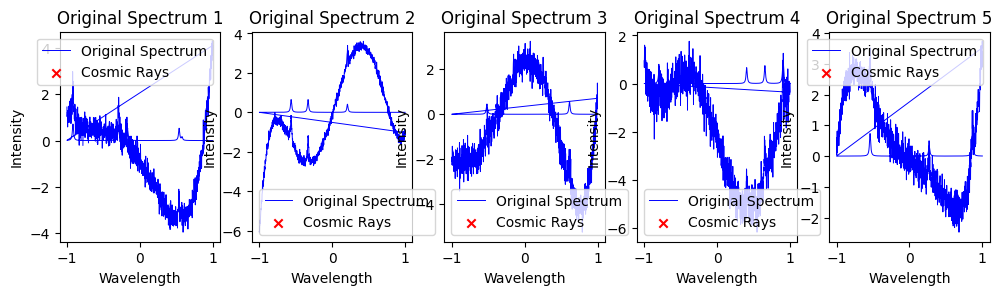

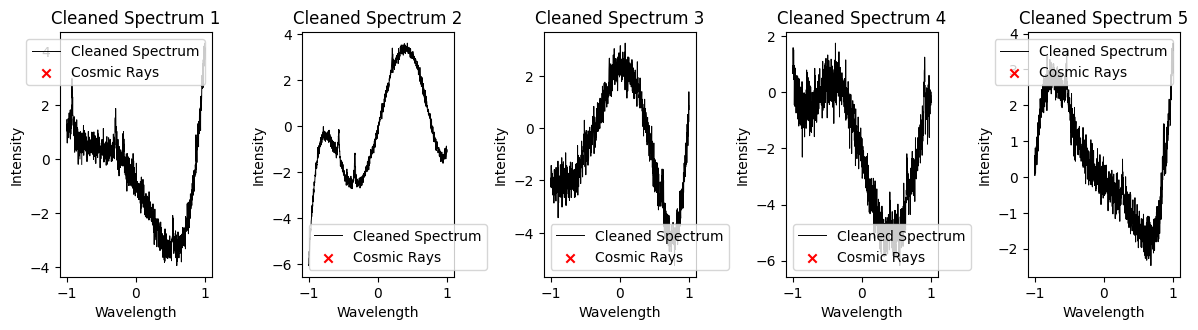

In [89]:
# Recalculate second difference
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Initialize a list to store original spectra
original_spectra = []

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id].copy()  # df instead of data and make a copy

    # Check if spectrum exists in data
    if not spectrum_data.empty:
        # Append the original spectrum to the list
        original_spectra.append(spectrum_data.copy())  # copy to avoid modifying the original data

        # Cosmic Ray Removal
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(spectrum_data['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 5.0
        cosmic_ray_indices_original = np.where(second_difference > threshold)[0]

        # Print or inspect cosmic_ray_indices array
        print(f"Cosmic Ray Indices for Original Spectrum {i + 1}:", cosmic_ray_indices_original)

        # 3) Replace these points using custom interpolation
        for index in cosmic_ray_indices_original:
            # Custom interpolation
            left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
            right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

            left_distance = index - left_index
            right_distance = right_index - index

            left_neighbor = spectrum_data.iloc[left_index]['Intensity']
            right_neighbor = spectrum_data.iloc[right_index]['Intensity']

            # Linear interpolation to replace cosmic ray spike
            interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
            spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

        # Drop duplicate entries in the 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append the cleaned spectrum to the list
        cleaned_spectra.append(spectrum_data)

# Plot original spectra with cosmic rays marked
plt.figure(figsize=(12, 6))
for i, original_spectrum_data in enumerate(original_spectra):
    plt.subplot(2, num_spectra, i + 1)
    plt.plot(original_spectrum_data['Wavelength'], original_spectrum_data['Intensity'], color='blue', label='Original Spectrum', linewidth=0.7)
    plt.scatter(original_spectrum_data['Wavelength'].iloc[cosmic_ray_indices_original.tolist()], original_spectrum_data['Intensity'].iloc[cosmic_ray_indices_original.tolist()] + 0.04, marker='x', color='red', label='Cosmic Rays')
    plt.title(f'Original Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

# Plot cleaned spectra
plt.figure(figsize=(12, 6))
for i, cleaned_spectrum_data in enumerate(cleaned_spectra):
    # Recalculate second_difference and cosmic_ray_indices for cleaned spectrum
    first_difference_cleaned = np.diff(cleaned_spectrum_data['Intensity'], n=1)
    second_difference_cleaned = np.diff(first_difference_cleaned, n=1)
    cosmic_ray_indices_cleaned = np.where(second_difference_cleaned > threshold)[0]

    plt.subplot(2, num_spectra, i + 1)
    plt.plot(cleaned_spectrum_data['Wavelength'], cleaned_spectrum_data['Intensity'], color='black', label='Cleaned Spectrum', linewidth=0.7)
    plt.scatter(cleaned_spectrum_data['Wavelength'].iloc[cosmic_ray_indices_cleaned.tolist()], cleaned_spectrum_data['Intensity'].iloc[cosmic_ray_indices_cleaned.tolist()] + 0.04, marker='x', color='red', label='Cosmic Rays')
    plt.title(f'Cleaned Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()  # Adjust layout (prevent overlapping)
plt.show()

Cosmic Ray Indices for Original Spectrum 1: []
Cosmic Ray Indices for Original Spectrum 2: []
Cosmic Ray Indices for Original Spectrum 3: []
Cosmic Ray Indices for Original Spectrum 4: []
Cosmic Ray Indices for Original Spectrum 5: []


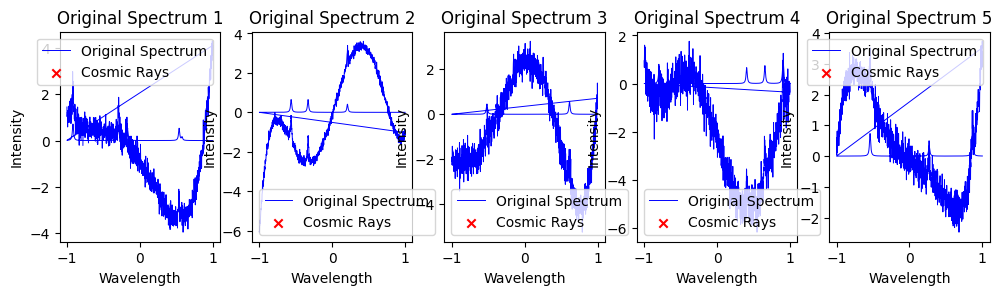

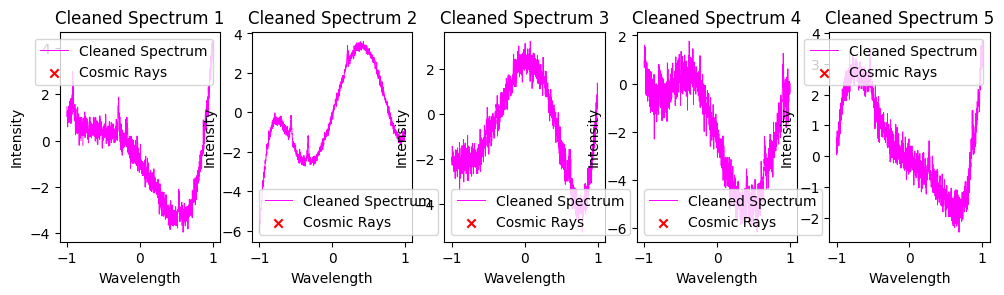

In [91]:
# Recalculate cosmic rays indices
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read file
df = pd.read_csv('synthetic_spectra.csv')

# Get unique spectrum IDs
spectrum_ids = df['Spectrum_ID'].unique()

# Initialize a list to store original spectra
original_spectra = []

# Initialize a list to store cleaned spectra
cleaned_spectra = []

# Iterate over all spectra
for i in range(num_spectra):
    spectrum_id = f'Spectrum_{i + 1}'
    spectrum_data = df[df['Spectrum_ID'] == spectrum_id].copy()  # df instead of data and make a copy

    # Check if spectrum exists in data
    if not spectrum_data.empty:
        # Append the original spectrum to the list
        original_spectra.append(spectrum_data)

        # Cosmic Ray Removal
        # 1) Calculate second difference of spectrum to accentuate sharp spikes (detect cosmic ray exceeding predefined threshold)
        first_difference = np.diff(spectrum_data['Intensity'], n=1)
        second_difference = np.diff(first_difference, n=1)

        # 2) Identify points where the second difference exceeds a predefined threshold, indicating a cosmic ray spike
        threshold = 5.0
        cosmic_ray_indices_original = np.where(second_difference > threshold)[0]

        # Print or inspect cosmic_ray_indices array
        print(f"Cosmic Ray Indices for Original Spectrum {i + 1}:", cosmic_ray_indices_original)

        # 3) Replace these points using custom interpolation
        for index in cosmic_ray_indices_original:
            # Custom interpolation
            left_index = np.clip(index - 1, 0, len(spectrum_data) - 1)
            right_index = np.clip(index + 1, 0, len(spectrum_data) - 1)

            left_distance = index - left_index
            right_distance = right_index - index

            left_neighbor = spectrum_data.iloc[left_index]['Intensity']
            right_neighbor = spectrum_data.iloc[right_index]['Intensity']

            # Linear interpolation to replace cosmic ray spike
            interpolated_value = left_neighbor + (right_neighbor - left_neighbor) / 2
            spectrum_data.loc[spectrum_data.index[index], 'Intensity'] = interpolated_value

        # Drop duplicate entries in the 'Wavelength' column
        spectrum_data = spectrum_data.drop_duplicates(subset=['Wavelength'])

        # Append the cleaned spectrum to the list
        cleaned_spectra.append(spectrum_data)

# Plot original spectra with cosmic rays marked
plt.figure(figsize=(12, 6))
for i, original_spectrum_data in enumerate(original_spectra):
    # Recalculate second_difference and cosmic_ray_indices for original spectrum
    first_difference_original = np.diff(original_spectrum_data['Intensity'], n=1)
    second_difference_original = np.diff(first_difference_original, n=1)
    cosmic_ray_indices_original = np.where(second_difference_original > threshold)[0]

    plt.subplot(2, num_spectra, i + 1)
    plt.plot(original_spectrum_data['Wavelength'], original_spectrum_data['Intensity'], color='blue', label='Original Spectrum', linewidth=0.7)
    plt.scatter(original_spectrum_data['Wavelength'].iloc[cosmic_ray_indices_original.tolist()], original_spectrum_data['Intensity'].iloc[cosmic_ray_indices_original.tolist()] + 0.04, marker='x', color='red', label='Cosmic Rays')
    plt.title(f'Original Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

# Plot cleaned spectra
plt.figure(figsize=(12, 6))
for i, cleaned_spectrum_data in enumerate(cleaned_spectra):
    # Recalculate second_difference and cosmic_ray_indices for cleaned spectrum
    first_difference_cleaned = np.diff(cleaned_spectrum_data['Intensity'], n=1)
    second_difference_cleaned = np.diff(first_difference_cleaned, n=1)
    cosmic_ray_indices_cleaned = np.where(second_difference_cleaned > threshold)[0]

    plt.subplot(2, num_spectra, i + 1)
    plt.plot(cleaned_spectrum_data['Wavelength'], cleaned_spectrum_data['Intensity'], color='magenta', label='Cleaned Spectrum', linewidth=0.7)
    plt.scatter(cleaned_spectrum_data['Wavelength'].iloc[cosmic_ray_indices_cleaned.tolist()], cleaned_spectrum_data['Intensity'].iloc[cosmic_ray_indices_cleaned.tolist()] + 0.04, marker='x', color='red', label='Cosmic Rays')
    plt.title(f'Cleaned Spectrum {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
